## **Business Problem:**

**Definition of problem:**

How can Delhivery use its raw logistics data to engineer meaningful features that enable accurate forecasting, better operational planning, and superior delivery performance

**Additional views:**

Timely and precise forecasts can minimize delays, reduce operational costs, and improve customer satisfaction. By transforming raw operational metrics into actionable insights, Delhivery can optimize resource allocation, anticipate demand fluctuations, and maintain a competitive edge in the logistics market.

## **Why This Analysis Matters to the Business**

**Improved Forecasting = Better Customer Experience**

*   Accurate delivery time predictions build trust with customers.
*   Reduces customer complaints and improves SLA (Service Level Agreement) compliance.

**Operational Efficiency = Lower Costs**

*   Identify bottlenecks (slow routes, delayed trips).
*   Optimize fleet usage, reduce idle time, and save fuel costs.

**Competitive Advantage**

*   Faster, more reliable deliveries make Delhivery a preferred partner for e-commerce and retail clients.
*   Insight-driven decision-making helps Delhivery stay ahead of logistics startups and traditional carriers.

**Data-Driven Strategy**

*   Enables planning for surge periods, route redesign, and dynamic pricing.
*   Informs product, tech, and operations teams through dashboards and ML models.

## **Evaluation Criteria**

### **1. Basic data cleaning and exploration:**

#### **a. Analyze the structure of the data.**

In [441]:
# Downloading the dataset
!gdown https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181 -O delhivery_data.csv

Downloading...
From: https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181
To: /content/delhivery_data.csv
100% 55.6M/55.6M [00:00<00:00, 89.9MB/s]


In [442]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid", palette="Set2")
df_org = pd.read_csv('delhivery_data.csv')

In [443]:
df_org.head()

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,10.435660,14.0,11.0,11.9653,1.272727,14.0,11.0,11.9653,1.272727
1,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:17:55,18.936842,24.0,20.0,21.7243,1.200000,10.0,9.0,9.7590,1.111111
2,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:01:19.505586,27.637279,40.0,28.0,32.5395,1.428571,16.0,7.0,10.8152,2.285714
3,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:39:57,36.118028,62.0,40.0,45.5620,1.550000,21.0,12.0,13.0224,1.750000
4,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,trip-153741093647649320,IND388121AAA,Anand_VUNagar_DC (Gujarat),IND388620AAB,Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 03:33:55,39.386040,68.0,44.0,54.2181,1.545455,6.0,5.0,3.9153,1.200000


Insights:
1. Multiple records for the same trip (trip_uuid).
 * The same trip_uuid appears multiple times with different cutoff_factor, cutoff_timestamp, and segment-level metrics.
 * This suggests the data is granular at the segment level rather than one row per trip.
 * Any aggregation for modeling will need to group by trip_uuid.

2. Variation in segment performance within the same trip.
 * actual_time, osrm_time, and segment_actual_time differ per row, meaning not all segments perform equally.
 * For example: Row 1: Segment factor ≈ 1.27 (slightly slower than OSRM estimate) and Row 3: Segment factor ≈ 2.28 (more than twice as slow as expected)
 * This indicates intra-trip delays and possible local bottlenecks.

3. Cutoff behavior varies.
 * Most rows have is_cutoff = TRUE but one row is FALSE.
 * cutoff_factor ranges widely (9 to 39), showing that cutoff-related delays can be significant and inconsistent.
 * Cutoff timestamps vary even within the same trip, which might be tied to package sorting or batching processes.

4. Distance and time deviations from plan.
 * factor > 1 in every row → actual time is always higher than OSRM estimated time.
 * Largest deviation in row 3 (1.43 trip factor, 2.28 segment factor) → potential hotspot for inefficiency.

In [444]:
# Shape of dataset
df_org.shape

(144867, 24)

The dataset, consisting of 144,867 records and 24 features, captures operational and logistics information from Delhivery’s services. This sample provides a foundation to uncover patterns, trends, and key factors influencing delivery performance, which can be generalized to improve decision-making across the company’s broader operations.

In [445]:
# Checking the datatype
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

Let us first understand column meanings and data types

Column meaning:

1.   data - tells whether the data is testing or training data
2.   trip_creation_time – Timestamp of trip creation
3. route_schedule_uuid – Unique Id for a particular route schedule
4. route_type – Transportation type
FTL – Full Truck Load: FTL shipments get to the destination sooner, as the truck is making no other pickups or drop-offs along the way
Carting: Handling system consisting of small vehicles (carts)
5. trip_uuid - Unique ID given to a particular trip (A trip may include different source and destination centers)
6. source_center - Source ID of trip origin
7. source_name - Source Name of trip origin
8. destination_cente – Destination ID
9. destination_name – Destination Name
10. od_start_time – Timestamp when trip actually started
11. od_end_time – Timestamp when trip ended. Used with start time to calculate actual duration.
12. start_scan_to_end_scan – Time taken to deliver from source to destination
13. is_cutoff – True : means It may get delayed, go in the next day’s batch, or require special handling, False : The trip was on time
14. cutoff_factor – A score that indicates how late a trip was created past the cutoff time.
15. cutoff_timestamp – The predefined latest time by which a trip must be created or dispatched to be considered on time for same-day processing or delivery
16. actual_distance_to_destination – Distance in Kms between source and destination warehouse
17. actual_time – Actual time taken to complete the delivery (Cumulative)
18. osrm_time – An open-source routing engine time calculator which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) and gives the time (Cumulative)
19. osrm_distance – An open-source routing engine which computes the shortest path between points in a given map (Includes usual traffic, distance through major and minor roads) (Cumulative)
20. factor – It is actual_time/osrm_time. As the actual_time increases factor also increases
21. segment_actual_time – This is a segment time. Time taken by the subset of the package delivery
22. segment_osrm_time – This is the OSRM segment time. Time taken by the subset of the package delivery
23. segment_osrm_distance – This is the OSRM distance. Distance covered by subset of the package delivery
24. segment_factor – It is segment_actual_time/segment_osrm_time. As the segment_actual_time increases segment_factor also increases








Identify which columns are trip-level and segment-level:

In [446]:
# Define trip-level and segment-level columns
trip_level_columns = [
    'data',
    'trip_creation_time',
    'route_schedule_uuid',
    'route_type',
    'trip_uuid'
]

segment_level_columns = [

    'source_center',
    'source_name',
    'destination_cente',
    'destination_name',
    'od_start_time',
    'od_end_time',
    'start_scan_to_end_scan',
    'is_cutoff',
    'cutoff_factor',
    'cutoff_timestamp',
    'actual_distance_to_destination',
    'actual_time',
    'osrm_time',
    'osrm_distance',
    'factor',
    'segment_actual_time',
    'segment_osrm_time',
    'segment_osrm_distance',
    'segment_factor'
]

# Create DataFrame
column_df = pd.DataFrame({
    'Trip-Level Columns': pd.Series(trip_level_columns),
    'Segment-Level Columns': pd.Series(segment_level_columns)
})

# Replace NaN with blank
column_df = column_df.fillna('')

# Display
column_df

,Trip-Level Columns,Segment-Level Columns
0,data,source_center
1,trip_creation_time,source_name
2,route_schedule_uuid,destination_cente
3,route_type,destination_name
4,trip_uuid,od_start_time
5,,od_end_time
6,,start_scan_to_end_scan
7,,is_cutoff
8,,cutoff_factor
9,,cutoff_timestamp


In [447]:
# Identify duplicate rows
df_org[df_org.duplicated()]

,data,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor


There are no duplicate rows

In [448]:
# Count how many segments (rows) exist for each unique trip_uuid in the dataset
segment_counts = df_org['trip_uuid'].value_counts()
segment_counts

,count
trip_uuid,
trip-153759210483476123,101
trip-153715938946690081,101
trip-153784927255069118,101
trip-153733005409156789,101
trip-153811219535896559,101
...,...
trip-153728911454561981,1
trip-153733734393817090,1
trip-153788576441831649,1


*  The dataset shows 14,817 unique trip_uuid values.

*  Some trips (like the top ones) are split into 101 segments (i.e., 101 rows per trip).

*  Some trips only have 1 segment.

**Conversion of categorical attributes to 'category'**


In [449]:
# Identifying the categorical attributes
cat_temp_df = pd.DataFrame(columns=['Column', 'Unique Count'])
for column in df_org.columns:
  new_row = {'Column': column, 'Unique Count': df_org[column].nunique()}
  cat_temp_df = pd.concat([cat_temp_df, pd.DataFrame([new_row])], ignore_index=True)
cat_temp_df

,Column,Unique Count
0,data,2
1,trip_creation_time,14817
2,route_schedule_uuid,1504
3,route_type,2
4,trip_uuid,14817
5,source_center,1508
6,source_name,1498
7,destination_center,1481
8,destination_name,1468
9,od_start_time,26369


A column is a good candidate for category if:

It has much fewer unique values compared to the total dataset
It represents categorical data.
For now we have done light EDA to fetch the categorical columns such as:

| data: 2 | route_type: 2 | is_cutoff: 2 |

However, There are other columns haing many unique values, but categorical in nature:

| route_schedule_uuid | source_center | source_name | destination_center | destination_name |

#### **b. Handle missing values in the data. (Missing value detection)**

In [450]:
df_org.isnull().sum()

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
route_type,0
trip_uuid,0
source_center,0
source_name,293
destination_center,0
destination_name,261
od_start_time,0


*  Upon analyzing the dataset, I found that the source_name and destination_name columns contained missing values, even though the corresponding source_center and destination_center were present.

*  Instead of dropping these rows or imputing with potentially misleading information, the missing values were replaced with a placeholder string "unknown_center". This approach preserved the integrity of the dataset, retained all rows, and ensured that categorical encoding or feature extraction could proceed without issues.

*  Additionally, this placeholder can serve as an implicit indicator of missing data during analysis or modeling, if needed.

**Missing values treatment**

In [451]:
# Fill NaN value with unknown_center
df_org_copy = df_org.copy()
df_org_copy['source_name'] = df_org_copy['source_name'].fillna('unknown_source_center')
df_org_copy['destination_name'] = df_org_copy['destination_name'].fillna('unknown_destination_center')
df_org_copy.isnull().sum()

,0
data,0
trip_creation_time,0
route_schedule_uuid,0
route_type,0
trip_uuid,0
source_center,0
source_name,0
destination_center,0
destination_name,0
od_start_time,0


No NaN values were found after handling the missing data

**Statistical Summary:**

For now we have done light EDA to get the statistical summary on the dataframe.

In [452]:
# Check numeric columns (float & int)
numeric_cols = df_org_copy.select_dtypes(include=['int64', 'float64']).columns
print("\n Numeric Columns Summary:")
print(df_org_copy[numeric_cols].describe().T)  # Transposed for better readability


 Numeric Columns Summary:
                                   count        mean          std         min  \
start_scan_to_end_scan          144867.0  961.262986  1037.012769   20.000000   
cutoff_factor                   144867.0  232.926567   344.755577    9.000000   
actual_distance_to_destination  144867.0  234.073372   344.990009    9.000045   
actual_time                     144867.0  416.927527   598.103621    9.000000   
osrm_time                       144867.0  213.868272   308.011085    6.000000   
osrm_distance                   144867.0  284.771297   421.119294    9.008200   
factor                          144867.0    2.120107     1.715421    0.144000   
segment_actual_time             144867.0   36.196111    53.571158 -244.000000   
segment_osrm_time               144867.0   18.507548    14.775960    0.000000   
segment_osrm_distance           144867.0   22.829020    17.860660    0.000000   
segment_factor                  144867.0    2.218368     4.847530  -23.444444   



Insights:
- start_scan_to_end_scan and total_trip_time_mins have very large ranges (min ≈ 20 mins, max ≈ 7,898 mins ≈ 5.5 days).

- Standard deviation is slightly higher than the mean, suggesting large spread & extreme outliers (likely due to operational delays or anomalies).

- Actual_distance_to_destination median ≈ 66, but max ≈ 1,927 — could indicate long-distance deliveries or data entry errors.

- Actual_time is often much longer than osrm_time, meaning real trips often exceed estimated routing engine times — could reflect traffic, waiting, or operational inefficiencies.

- Factor and segment_factor mostly stay in the 1.3–2.2 range (normal trips), but max values are extreme (factor up to 77, segment_factor up to 574) — likely data errors or rare extreme events.

- Negative values in segment_actual_time and segment_factor are invalid and should be investigated/cleaned.

- Segment_osrm_time median = 17 mins, segment_actual_time median = 29 mins → actual consistently longer than expected.

- Segment_osrm_distance median = ~23.5 units, reasonable spread compared to trip-level distances.

- cutoff_factor median = 66, but max = 1,927 — large outliers present; needs further exploration to see if these are due to specific customer locations, delayed pickups, or system anomalies.

In [453]:
# Check categorical columns (object, string, category)
categorical_cols = df_org_copy.select_dtypes(include=['object', 'string', 'category']).columns
print("\n Categorical Columns Summary:")
print(df_org_copy[categorical_cols].describe().T)


 Categorical Columns Summary:
                      count unique  \
data                 144867      2   
trip_creation_time   144867  14817   
route_schedule_uuid  144867   1504   
route_type           144867      2   
trip_uuid            144867  14817   
source_center        144867   1508   
source_name          144867   1499   
destination_center   144867   1481   
destination_name     144867   1469   
od_start_time        144867  26369   
od_end_time          144867  26369   
cutoff_timestamp     144867  93180   

                                                                   top    freq  
data                                                          training  104858  
trip_creation_time                          2018-09-22 04:55:04.835022     101  
route_schedule_uuid  thanos::sroute:4029a8a2-6c74-4b7e-a6d8-f9e069f...    1812  
route_type                                                         FTL   99660  
trip_uuid                                      trip-15375921048347612

Insights:

- data has only two unique values, with "training" dominating (~72%).

- route_type is also binary, with "FTL" (Full Truck Load) covering ~69% of trips.

- "Gurgaon_Bilaspur_HB (Haryana)" is the most frequent source ~16% and destination ~10%, indicating it’s a major node in the network.

**Visual Analysis (distribution plots of all the continuous variable(s), boxplots of all the categorical variables) | Comments on range of attributes & outliers**

**- Histogram : distribution plots of all the continuous variable(s) | Comments on distribution (Univariate)**

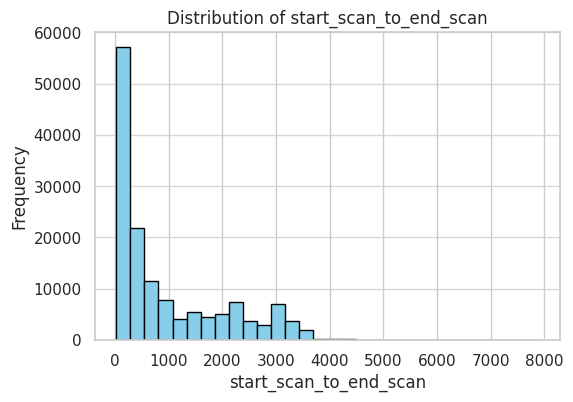

In [454]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['start_scan_to_end_scan'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of start_scan_to_end_scan')
plt.xlabel('start_scan_to_end_scan')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
1. Majority of Segment Transfers Are Fast
  - Overwhelming number of segments complete within 0–1000 minutes (~0–16.6 hours).
  - This suggests that most logistics or delivery operations are functioning efficiently across segments.
2. Presence of Long-Tail Delays
 - A small but significant number of segments take 3000–8000 minutes (2–5.5 days).
 - These are likely outliers and may represent exceptions or systemic inefficiencies
3. Right-Skewed Distribution
 - The histogram shows a steep drop-off after the first bin, confirming that delays are not evenly distributed.
 - Suggests that delays are concentrated in specific cases rather than widespread

**Business Implications:**
1. Operational Optimization
 - Investigate segments consistently falling in the long-tail to identify root causes (e.g., route bottlenecks, hub delays, manual errors).
 - Implement targeted interventions like rerouting, automation, or staff training
2. SLA Compliance Risk
 - Delays beyond 1000 minutes may breach service-level agreements.
 - Monitoring and alerting systems should flag these cases in real time
3. Customer Experience Impact
 - Longer scan-to-scan times can lead to delayed deliveries, affecting customer satisfaction.
4. Cost Management
 - Extended segment times may increase warehousing, labor, and transportation costs.


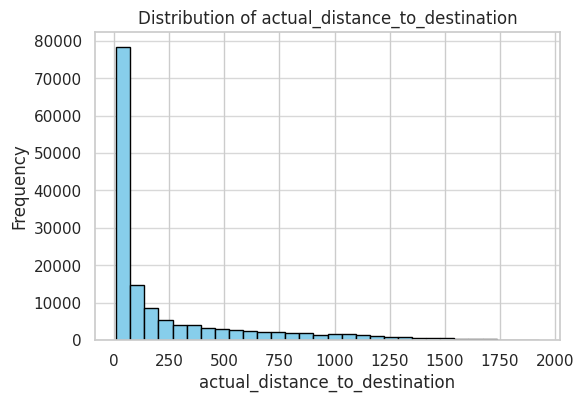

In [455]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['actual_distance_to_destination'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of actual_distance_to_destination')
plt.xlabel('actual_distance_to_destination')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
1. Distance Distribution Reveals Network Spread
 - If most destinations fall within a certain range (e.g., 0–500 km), it suggests a regional or intra-city logistics focus.
2. Clusters of Short-Distance Deliveries
 - High frequency of short-distance destinations may imply: Dense urban delivery zones
3. Presence of Long-Distance Outliers
 - A smaller set of deliveries spans large distances, possibly inter-state or cross-border.

**Business Implications:**

1. Route Optimization
 - Short-distance clusters can benefit from route planning tools to reduce fuel, time, and cost.
2. Fleet Allocation
 - Short vs. long-haul deliveries may require different vehicle types or driver shifts.
 - Data-driven fleet deployment can reduce idle time and improve asset utilization
3. Strategic Expansion
 - If long-distance deliveries are growing, it may justify new hubs or partnerships in distant regions.



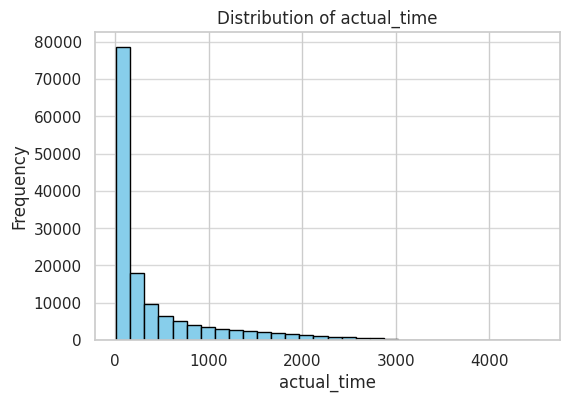

In [456]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['actual_time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of actual_time')
plt.xlabel('actual_time')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
1. Time Efficiency Patterns
 - If most deliveries are completed within a few hundred minutes, it suggests strong operational efficiency.
2. Segment-Level Performance
 - Segment-level actual_time can help identify which legs of the journey are slowest.
 - Useful for pinpointing bottlenecks in multi-hop delivery routes.

**Business Implications:**
1. SLA Monitoring and Compliance
 - Knowing actual delivery times helps validate whether SLAs are being met.
2. Customer Experience Enhancement
 - Predictable and fast delivery times improve customer satisfaction.
3. Cost Optimization
 - Longer delivery times may increase labor and fuel costs.
 - Identifying and addressing slow segments can reduce operational expenses.

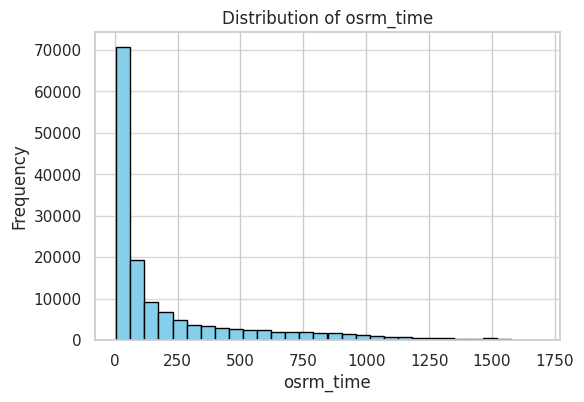

In [457]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['osrm_time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of osrm_time')
plt.xlabel('osrm_time')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
1. Concentration of Expected Times
 - The majority of deliveries have expected times between 0 and 250 minutes.
 - This suggests that most routes are short to medium range, likely within urban or regional zones.
2. Long Tail of High Expected Times
 - A small number of deliveries have expected times exceeding 1000 minutes (~16+ hours).

**Business Implications:**
1. Few deliveries > 1000 min
 - Long-haul routes may be costly or inefficient
2. Most deliveries < 250 min
 - Core operations are short-range and time-sensitive

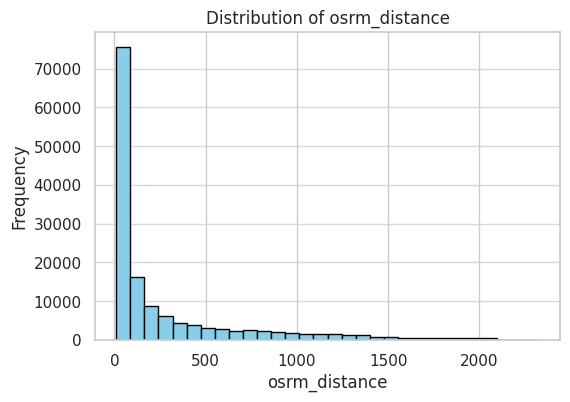

In [458]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['osrm_distance'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of osrm_distance')
plt.xlabel('osrm_distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
- Concentration of Short Distances
Most values are clustered at the lower end of the distance spectrum, indicating that the majority of trips or deliveries are short-range.
- Sharp Decline in Long Distances
There's a steep drop-off in frequency as distance increases, suggesting that long-distance trips are relatively rare.

**Business Implications:**
- Local Optimization Opportunities
Since most trips are short, businesses can focus on optimizing local delivery routes. This could mean:
 - Using smaller, more fuel-efficient vehicles
 - Implementing bike or foot delivery in dense urban zones
 - Reducing delivery time windows for better customer satisfaction

- Smarter Resource Allocation

  Understanding distance distribution helps in:
 - Deploying more vehicles and staff in high-frequency zones
 - Avoiding over-investment in areas with low delivery demand


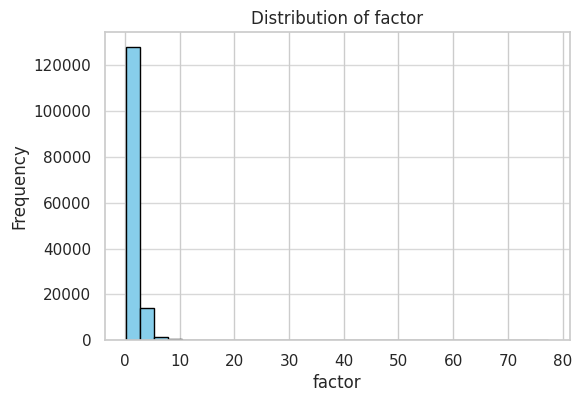

In [459]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['factor'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of factor')
plt.xlabel('factor')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
- Highly Skewed Distribution -
The histogram shows a strong concentration of values near zero, with frequency dropping sharply as the factor increases. This indicates a right-skewed distribution.

- Presence of Outliers -
A few data points lie far from the bulk of the distribution, suggesting outliers with significantly higher factor values

**Business Implications:**
- Predictive Modeling Potential -
The skewed nature of the data suggests that regression or classification models could be trained to predict high factor cases, enabling proactive decision-making.

- Customer Segmentation
If factor is customer-related (e.g., engagement, spend, risk), segmenting customers by factor value can help tailor marketing, support, or pricing strategies.

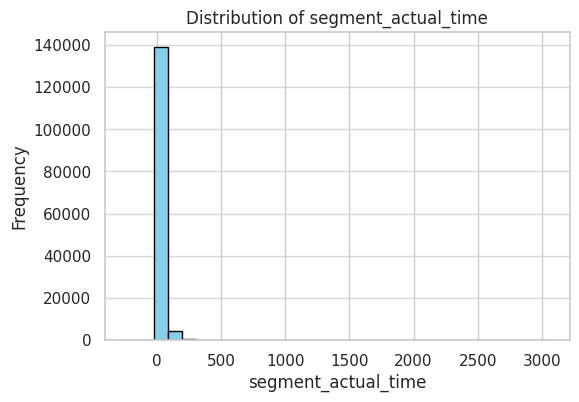

In [460]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['segment_actual_time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of segment_actual_time')
plt.xlabel('segment_actual_time')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
- Strong Right Skew -
The majority of segment_actual_time values are clustered near zero, with a long tail extending toward higher values (up to ~3000). This indicates a right-skewed distribution.

- High Frequency of Short Durations -
Most segments take a relatively short time to complete, suggesting operational efficiency or short-distance tasks

**Business Implications:**
- Investigate Long-Duration Outliers

  The long tail may represent:
 - Traffic congestion, route inefficiencies, or operational bottlenecks
 - Specific customer segments or regions requiring special handling
These should be analyzed and addressed to reduce variability.

- Improve Forecasting Models -
The skewed distribution suggests that mean values may be misleading. Use median or percentile-based metrics for more accurate planning and reporting.


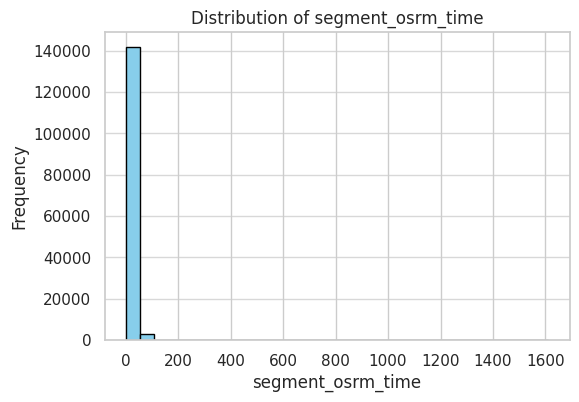

In [461]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['segment_osrm_time'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of segment_osrm_time')
plt.xlabel('segment_osrm_time')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
- Strong Right Skew -
The histogram shows a sharp peak near zero, with a long tail extending toward higher values (up to ~1600). This indicates a right-skewed distribution.

- Sparse Long-Duration Segments -
A few segments take significantly longer, possibly due to longer distances, traffic conditions, or routing anomalies.

**Business Implications:**
- Routing Strategy Refinement

  OSRM estimates can guide:
  - Route planning algorithms to avoid high-duration paths
  - Dynamic rerouting during peak traffic or adverse condition

- Predictive Modeling Opportunities

  The skewed distribution is ideal for building models that:
  - Predict segment duration based on route features
  - Identify segments likely to exceed expected time thresholds


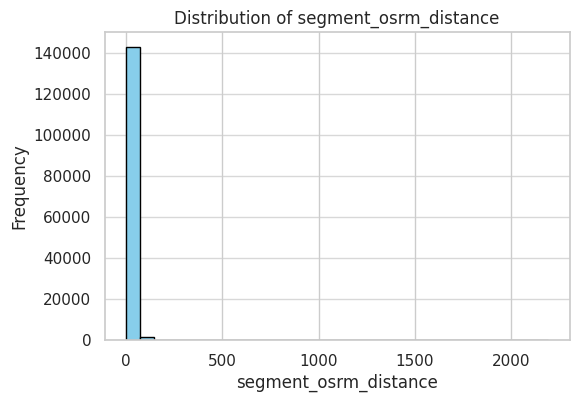

In [462]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['segment_osrm_distance'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of segment_osrm_distance')
plt.xlabel('segment_osrm_distance')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**

- High Concentration of Short Distances -
  The majority of segment distances are clustered near zero, indicating that most routes are short and likely local.
- Presence of Long-Distance Outliers -
  A small number of segments span significantly larger distances, suggesting rare but impactful long-haul routes.

**Business Implications**
- Local Route Optimization -
  Businesses should prioritize efficiency in short-distance logistics—streamlining local deliveries, reducing fuel costs, and improving turnaround times.
- Strategic Planning for Long Routes -
  Long-distance segments may require dedicated resources, alternate transport modes, or dynamic pricing to maintain profitability and service quality


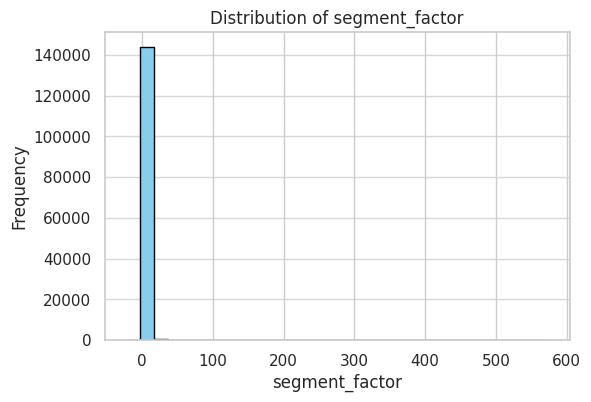

In [463]:
plt.figure(figsize=(6, 4))
plt.hist(df_org_copy['segment_factor'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title(f'Distribution of segment_factor')
plt.xlabel('segment_factor')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Insights:**
- Dominance of Low Segment Factors -
The histogram shows a sharp peak near zero, meaning most segments have minimal variation or complexity.
- Long Tail of High Segment Factors -
A few segments extend far beyond the norm, indicating rare but potentially high-impact outliers.

**Business Implications:**
- Standardization Opportunities -
Since most segments are low-complexity, businesses can streamline operations by standardizing processes, automating workflows, and reducing overhead in these areas.
- Targeted Strategy for Outliers -
High-factor segments may represent niche markets or unique customer needs. Tailored solutions—like premium services or specialized logistics—could unlock hidden value and competitive advantage.


**Boxplots of all the categorical variables | Comments on relationship (bivariate)**

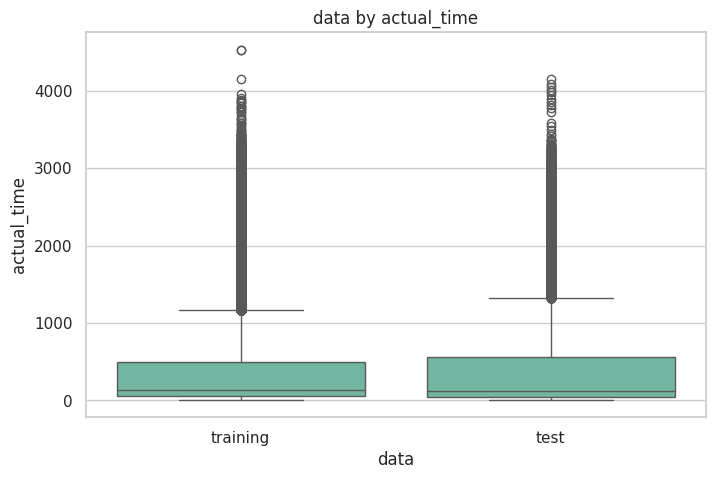

In [464]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='data', y='actual_time', data=df_org_copy)
plt.title(f'data by actual_time')
plt.xticks(rotation=0)
plt.show()

**Insights:**
- Consistent Median Across Categories -
Both training and test datasets show a median actual_time around 500, indicating stable performance across phases.

- Significant Outliers in Both Sets -
Outliers reaching up to ~4000 suggest sporadic spikes in processing time, despite similar interquartile ranges.

**Business Implications:**
- Reliable Process Benchmarking -
The consistent median allows businesses to confidently set expectations and SLAs for model training and testing durations, aiding in resource planning and forecasting.

- Need for Exception Handling -
The presence of extreme outliers highlights the importance of monitoring and mitigating edge cases—potentially through anomaly detection, better data preprocessing, or infrastructure scaling.


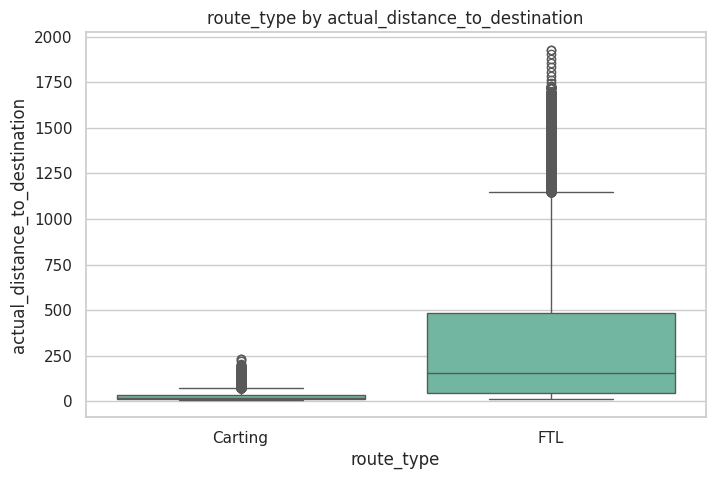

In [465]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='route_type', y='actual_distance_to_destination', data=df_org_copy)
plt.title(f'route_type by actual_distance_to_destination')
plt.xticks(rotation=0)
plt.show()

**Insights:**
- Carting Routes Are Short and Consistent -
The Carting route type shows a narrow range and low median distance, indicating it's primarily used for short, predictable deliveries.

- FTL Routes Span Long and Variable Distances -
The FTL (Full Truck Load) route type has a much wider spread and higher median, suggesting it's deployed for longer and more diverse delivery routes.

**Business Implications:**
- Optimize Local Logistics with Carting -
Businesses can leverage Carting for urban or intra-regional deliveries, focusing on speed, cost-efficiency, and frequent dispatches.

- Strategic Deployment of FTL for Bulk Transport -
FTL is ideal for long-haul or intercity shipments. Companies should align FTL usage with bulk order fulfillment, reducing per-unit transport cost and improving load utilization.


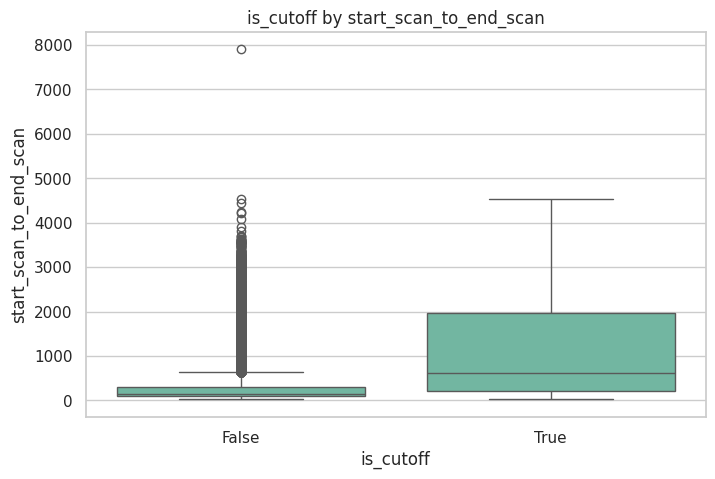

In [466]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_cutoff', y='start_scan_to_end_scan', data=df_org_copy)
plt.title(f'is_cutoff by start_scan_to_end_scan')
plt.xticks(rotation=0)
plt.show()

**Insights:**
- Cutoff Is False -
 - IQR for False cutoff shows less scan time between source and destination.
 - Timely shipments are stable and predictable, which helps in customer satisfaction and planning.

- Cutoff Is True -
 - IQR for True cutoff shows more scan time between source and destination.
 - Delayed shipments, however, introduce uncertainty, making it harder for operations teams to allocate resources efficiently.


- Tighter Control When Cutoff Is True -
The True category has a more concentrated distribution with fewer outliers, suggesting that applying the cutoff leads to more predictable and controlled scan durations.

**Business Implications:**
- Operational stability -
Smaller IQR for timely shipments indicates consistent processes, while larger IQR for delayed shipments points to multiple, unpredictable delay causes that need addressing.

- Customer trust – Reducing variability in delayed shipments can improve reliability perceptions, even when delays occur.


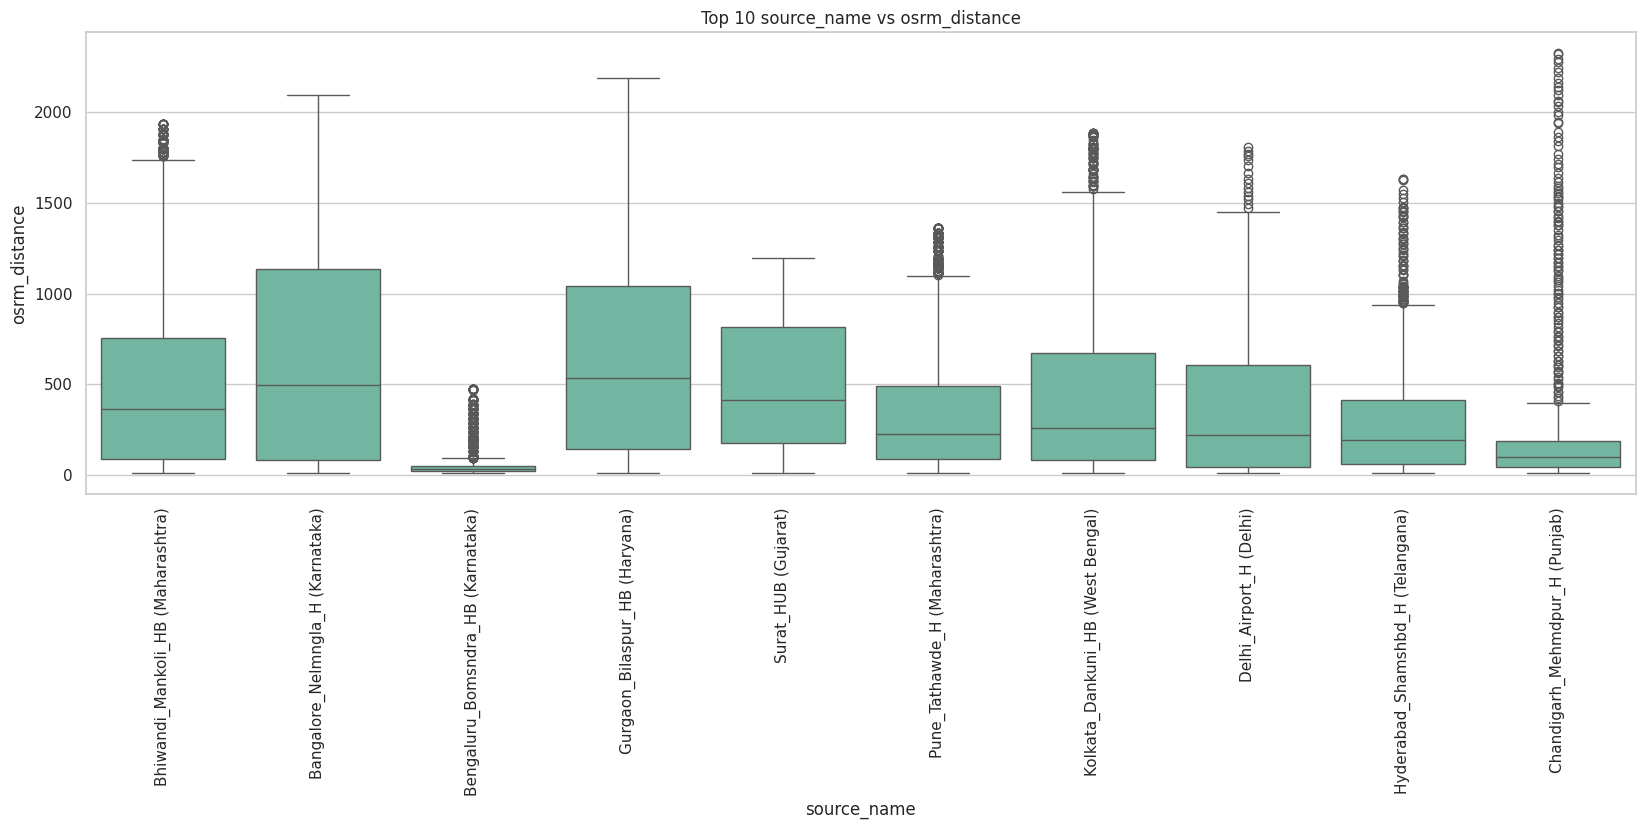

In [467]:
top_n = 10
top_sources = df_org_copy['source_name'].value_counts().nlargest(top_n).index

# Filter dataset
df_top_sources = df_org_copy[df_org_copy['source_name'].isin(top_sources)]

# Plot
plt.figure(figsize=(20, 6))
sns.boxplot(x='source_name', y='osrm_distance', data=df_top_sources)
plt.xticks(rotation=90)
plt.title(f'Top {top_n} source_name vs osrm_distance')
plt.show()

**Insights:**

- Bengaluru_Bommasandra_HB shows very small OSRM distances with minimal spread, suggesting it primarily serves short-distance deliveries.

- Chandigarh_Mehatpur_H has the smallest median but also very high maximum outliers, indicating occasional long-distance shipments from this hub.

**Business Implications:**

- Short-haul efficiency – Hubs with small, consistent distances can be optimized for frequent, faster deliveries, improving customer satisfaction in local markets.

- Resource flexibility – Hubs with low median distances but extreme outliers need contingency planning (e.g., larger vehicles or inter-hub transfers) to handle occasional long routes without disrupting regular operations.

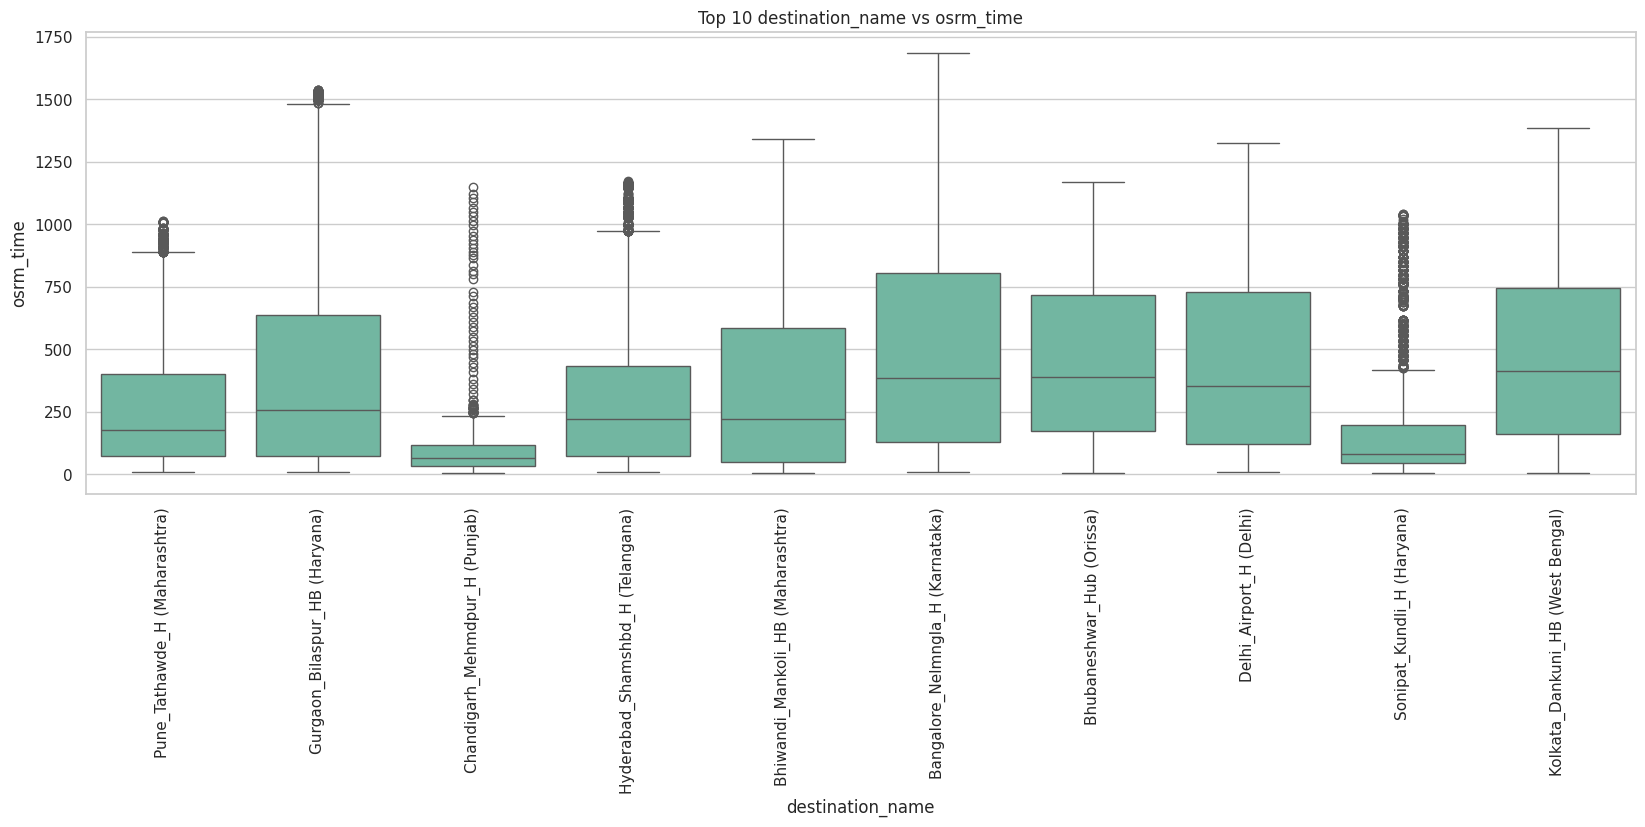

In [468]:
top_n = 10
top_sources = df_org_copy['destination_name'].value_counts().nlargest(top_n).index

# Filter dataset
df_top_sources = df_org_copy[df_org_copy['destination_name'].isin(top_sources)]

# Plot
plt.figure(figsize=(20, 6))
sns.boxplot(x='destination_name', y='osrm_time', data=df_top_sources)
plt.xticks(rotation=90)
plt.title(f'Top {top_n} destination_name vs osrm_time')
plt.show()

**Insights:**

- Chandigarh_Mehndpur_H has a very low median OSRM time with minimal spread, but shows occasional extreme outliers, suggesting mostly quick deliveries with rare long hauls.

- Bangalore_Nelmangla_H and Kolkata_Dankuni_HB have high medians and wide IQRs, indicating consistently long travel times with high variability.

**Business Implications:**

- Hub specialization – Destinations like Chandigarh_Mehndpur_H can be optimized as quick-turnaround points, improving throughput for short-haul deliveries.

- Route performance management – High-median, high-variability hubs may require deeper route optimization, alternate routing strategies, or better scheduling to reduce unpredictability in delivery times.

Comments on range of attributes, outliers of various attributes

**Comparison & Visualization of time and distance fields**

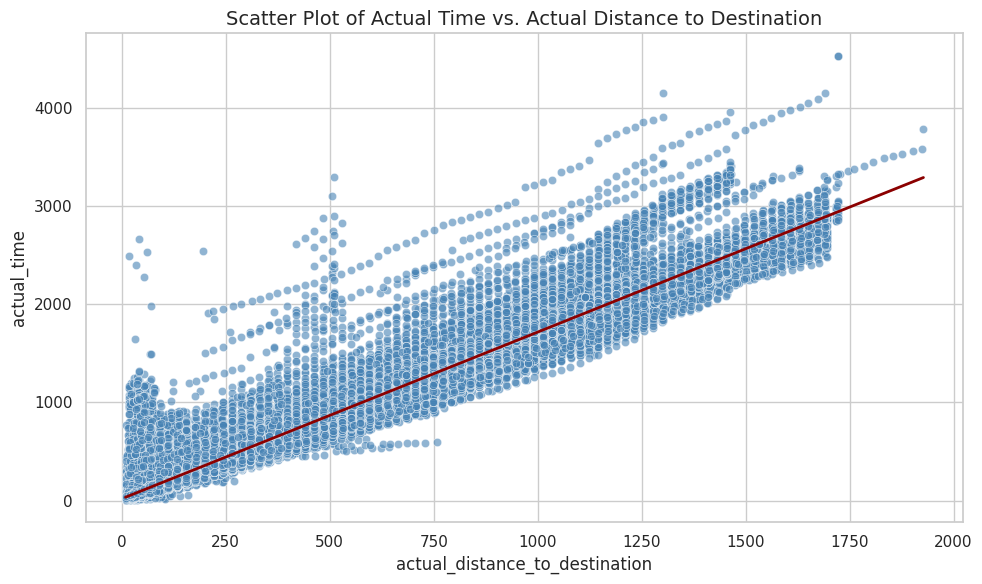

In [469]:
# Set plot style
sns.set_theme(style="whitegrid", palette="Set2")

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_org_copy,
    x="actual_distance_to_destination",
    y="actual_time",
    color="steelblue",
    alpha=0.6
)

# Add labels and title
plt.title("Scatter Plot of Actual Time vs. Actual Distance to Destination", fontsize=14)
plt.xlabel("Actual Distance to Destination (km or units)", fontsize=12)
plt.ylabel("Actual Time (minutes)", fontsize=12)

# Optional: Add regression line
sns.regplot(
    data=df_org_copy,
    x="actual_distance_to_destination",
    y="actual_time",
    scatter=False,
    color="darkred",
    line_kws={"linewidth": 2}
)

plt.tight_layout()
plt.show()

What the Plot Shows
- The scatter plot compares actual_time (in minutes) against actual_distance_to_destination (in kilometers).
- Each blue dot represents a delivery segment.
- The red line indicates the trend—how time scales with distance.

Insights:
1. Positive Correlation
  - As distance increases, actual time generally increases.
  - This confirms a logical relationship between travel time and distance
2. High Variability
 - Some deliveries with similar distances show very different times, suggesting:
 - Route inefficiencies
 - Traffic or handling delays
 - Operational inconsistencies
3. Outliers
 - A few points lie far above the trend line, indicating significant delays for relatively short distances.
 - These should be investigated for root causes.

Business Implications:
- Route Optimization: Use this relationship to benchmark expected delivery times and flag inefficiencies
- SLA Calibration: Helps set realistic time expectations based on distance.
- Performance Monitoring: Identify segments or regions where actual time consistently exceeds expected norms.
- Predictive Modeling: This correlation can feed into ETA prediction models for better customer communication and planning.

#### **c. Try merging the rows using the hint mentioned above (Merging of rows and aggregation of fields)**

In [470]:
# Convert to datetime
df_org_copy['trip_creation_time'] = pd.to_datetime(df_org_copy['trip_creation_time'], format='mixed')
df_org_copy['od_start_time'] = pd.to_datetime(df_org_copy['od_start_time'], format='mixed')
df_org_copy['od_end_time'] = pd.to_datetime(df_org_copy['od_end_time'], format='mixed')
df_org_copy['cutoff_timestamp'] = pd.to_datetime(df_org_copy['cutoff_timestamp'], format='mixed')
df_org_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   data                            144867 non-null  object        
 1   trip_creation_time              144867 non-null  datetime64[ns]
 2   route_schedule_uuid             144867 non-null  object        
 3   route_type                      144867 non-null  object        
 4   trip_uuid                       144867 non-null  object        
 5   source_center                   144867 non-null  object        
 6   source_name                     144867 non-null  object        
 7   destination_center              144867 non-null  object        
 8   destination_name                144867 non-null  object        
 9   od_start_time                   144867 non-null  datetime64[ns]
 10  od_end_time                     144867 non-null  datetim

I have bifurcated the columns based on Trip-level and Segment-level.
1. Trip-level columns:

  I considered columns as trip-level when their values remained constant for each trip_uuid, representing attributes or metrics aggregated across the entire trip.
2. Segment-level columns:

  I classified columns as segment-level when their values varied within the same trip_uuid, reflecting characteristics or measures specific to individual segments of the trip.

**Segment level aggregation**

In [471]:
# Segment level aggregation
segment_aggregations = {
    'data':'first',
    'trip_creation_time':'first',
    'route_schedule_uuid':'first',
    'route_type':'first',
    'source_name':'first',
    'destination_name':'last',
    'od_start_time':'min',
    'od_end_time':'max',
    'start_scan_to_end_scan':'sum',
    'is_cutoff': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'cutoff_factor': 'mean',
    'cutoff_timestamp':'max',
    'actual_distance_to_destination':'sum',
    'actual_time':'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'factor': 'mean',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'segment_factor': 'mean'
}
df_segment = df_org_copy.groupby(
    ['trip_uuid','source_center','destination_center'], sort = False
).agg(segment_aggregations).reset_index()
df_segment

,trip_uuid,source_center,destination_center,data,trip_creation_time,route_schedule_uuid,route_type,source_name,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,trip-153741093647649320,IND388121AAA,IND388620AAB,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,Anand_VUNagar_DC (Gujarat),Khambhat_MotvdDPP_D (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 04:27:55,132.513850,208.0,143.0,166.0092,1.399351,67.0,44.0,49.4772,1.523911
1,trip-153741093647649320,IND388620AAB,IND388320AAA,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,Khambhat_MotvdDPP_D (Gujarat),Anand_Vaghasi_IP (Gujarat),2018-09-20 04:47:45.236797,...,2018-09-20 06:15:58,139.045383,302.0,141.0,169.6547,2.081727,100.0,44.0,53.2334,2.654545
2,trip-153768492602129387,IND421302AAG,IND411033AAA,training,2018-09-23 06:42:06.021680,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,FTL,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-23 06:42:06.021680,...,2018-09-23 11:05:19,328.874342,555.0,308.0,408.7086,1.769279,180.0,106.0,130.4089,1.781363
3,trip-153693976643699843,IND400011AAA,IND400072AAD,training,2018-09-14 15:42:46.437249,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,Carting,LowerParel_CP (Maharashtra),Mumbai_Chndivli_PC (Maharashtra),2018-09-14 15:42:46.437249,...,2018-09-14 16:29:54,25.787125,106.0,27.0,30.2285,3.965909,60.0,16.0,18.7941,3.490909
4,trip-153687145942424248,IND562132AAA,IND560099AAB,training,2018-09-13 20:44:19.424489,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,FTL,Bangalore_Nelmngla_H (Karnataka),Bengaluru_Bomsndra_HB (Karnataka),2018-09-13 20:44:19.424489,...,2018-09-13 23:25:20,63.441846,97.0,83.0,81.1021,1.132075,67.0,56.0,53.9310,1.211538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26363,trip-153799142965708367,IND457226AAA,IND382430AAB,training,2018-09-26 19:50:29.657378,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,FTL,Jaora_RtlamNka_D (Madhya Pradesh),Ahmedabad_East_H_1 (Gujarat),2018-09-27 06:55:50.265761,...,2018-09-27 15:38:16,1991.134279,3351.0,1919.0,2621.5580,1.798854,479.0,328.0,420.2195,1.365360
26364,trip-153695073416451616,IND400102AAB,IND421302AAG,training,2018-09-14 18:45:34.164734,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,Carting,Mumbai_Jogeshwri_L (Maharashtra),Bhiwandi_Mankoli_HB (Maharashtra),2018-09-14 18:45:34.164734,...,2018-09-15 00:21:55,42.156596,386.0,56.0,63.4385,6.388387,344.0,36.0,40.1360,14.567273
26365,trip-153761584139918815,IND421302AAG,IND411033AAA,training,2018-09-22 11:30:41.399439,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,FTL,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-22 11:30:41.399439,...,2018-09-22 20:19:23,331.227507,789.0,310.0,411.5048,2.460665,288.0,111.0,129.3412,3.121489
26366,trip-153718412883843340,IND600056AAB,IND600032AAB,training,2018-09-17 11:35:28.838714,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,Carting,MAA_Poonamallee_HB (Tamil Nadu),Chennai_Hub (Tamil Nadu),2018-09-17 11:35:28.838714,...,2018-09-17 12:57:20,87.385258,248.0,89.0,98.1093,2.884707,82.0,31.0,36.7671,2.531250


In [472]:
# Trip level aggregation
trip_aggregation = {
    'data':'first',
    'trip_creation_time':'first',
    'route_schedule_uuid':'first',
    'route_type':'first',
    'source_center':'first',
    'destination_center':'last',
    'source_name':'first',
   'destination_name':'last',
    'od_start_time':'min',
    'od_end_time':'max',
    'start_scan_to_end_scan':'sum',
    'is_cutoff': lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0],
    'cutoff_factor': 'mean',
    'cutoff_timestamp':'max',
    'actual_distance_to_destination':'sum',
    'actual_time':'sum',
    'osrm_time': 'sum',
    'osrm_distance': 'sum',
    'factor': 'mean',
    'segment_actual_time': 'sum',
    'segment_osrm_time': 'sum',
    'segment_osrm_distance': 'sum',
    'segment_factor': 'mean'
}
df_trip = df_segment.groupby('trip_uuid', sort = False).agg(trip_aggregation).reset_index()
df_trip

,trip_uuid,data,trip_creation_time,route_schedule_uuid,route_type,source_center,destination_center,source_name,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,trip-153741093647649320,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,IND388121AAA,IND388320AAA,Anand_VUNagar_DC (Gujarat),Anand_Vaghasi_IP (Gujarat),2018-09-20 03:21:32.418600,...,2018-09-20 06:15:58,271.559234,510.0,284.0,335.6639,1.740539,167.0,88.0,102.7106,2.089228
1,trip-153768492602129387,training,2018-09-23 06:42:06.021680,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-23 06:42:06.021680,...,2018-09-23 11:05:19,328.874342,555.0,308.0,408.7086,1.769279,180.0,106.0,130.4089,1.781363
2,trip-153693976643699843,training,2018-09-14 15:42:46.437249,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,Carting,IND400011AAA,IND400072AAD,LowerParel_CP (Maharashtra),Mumbai_Chndivli_PC (Maharashtra),2018-09-14 15:42:46.437249,...,2018-09-14 16:29:54,25.787125,106.0,27.0,30.2285,3.965909,60.0,16.0,18.7941,3.490909
3,trip-153687145942424248,training,2018-09-13 20:44:19.424489,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,FTL,IND562132AAA,IND683511AAA,Bangalore_Nelmngla_H (Karnataka),Aluva_Peedika_H (Kerala),2018-09-13 20:44:19.424489,...,2018-09-14 12:45:25,3061.332439,6361.0,3629.0,4027.4529,1.478459,799.0,502.0,560.5092,1.422855
4,trip-153825970514894360,test,2018-09-29 22:21:45.149226,thanos::sroute:0904e75c-b3ac-4278-96cf-802835a...,FTL,IND141003AAB,IND000000ACA,Ludhiana_GillChwk_DC (Punjab),Ludhiana_MilrGanj_HB (Punjab),2018-09-30 02:22:04.138164,...,2018-09-30 05:50:12,141.309843,213.0,184.0,180.2745,1.239316,151.0,137.0,115.7501,1.195547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153799142965708367,training,2018-09-26 19:50:29.657378,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,FTL,IND454001AAA,IND382430AAB,Dhar_Trimurti_D (Madhya Pradesh),Ahmedabad_East_H_1 (Gujarat),2018-09-27 02:48:14.315366,...,2018-09-27 15:38:16,2261.006561,3681.0,2238.0,2929.2445,1.235861,617.0,507.0,596.7341,1.213298
14813,trip-153695073416451616,training,2018-09-14 18:45:34.164734,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,Carting,IND400102AAB,IND421302AAG,Mumbai_Jogeshwri_L (Maharashtra),Bhiwandi_Mankoli_HB (Maharashtra),2018-09-14 18:45:34.164734,...,2018-09-15 00:21:55,42.156596,386.0,56.0,63.4385,6.388387,344.0,36.0,40.1360,14.567273
14814,trip-153761584139918815,training,2018-09-22 11:30:41.399439,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-22 11:30:41.399439,...,2018-09-22 20:19:23,331.227507,789.0,310.0,411.5048,2.460665,288.0,111.0,129.3412,3.121489
14815,trip-153718412883843340,training,2018-09-17 11:35:28.838714,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,Carting,IND600056AAB,IND600032AAB,MAA_Poonamallee_HB (Tamil Nadu),Chennai_Hub (Tamil Nadu),2018-09-17 11:35:28.838714,...,2018-09-17 12:57:20,87.385258,248.0,89.0,98.1093,2.884707,82.0,31.0,36.7671,2.531250


### **2. Build some features to prepare the data for actual analysis. Extract features from the below fields (Feature Creation):**

#### **a. Destination Name: Split and extract features out of destination. City-place-code (State)**

In [473]:
def parse_location(s):
    if pd.isna(s):
        return pd.Series([pd.NA, pd.NA, pd.NA, pd.NA])

    s = str(s).strip()
    # 1) extract state if present in parentheses
    state_match = re.search(r'\((.*?)\)', s)
    state = state_match.group(1).strip() if state_match else pd.NA
    if isinstance(state, str) and state.lower() == 'unknown':
        state = pd.NA

    # 2) remove parentheses part and strip
    main = re.sub(r'\(.*?\)', '', s).strip(' _')

    if main == '':
        return pd.Series([pd.NA, pd.NA, pd.NA, state])

    # 3) split on underscores (limit to 3 splits to cover up to 4 tokens)
    parts = [p.strip() for p in main.split('_', 3)]

    # 4) remove empty parts and 'unknown'
    parts = [p for p in parts if p and p.lower() != 'unknown']

    # 5) identify code: if last token length <= 2 -> code
    code = pd.NA
    if parts:
        last = parts[-1]
        # treat tokens with <=2 chars as code (adjust rule if needed)
        if len(last) <= 2:
            code = last
            parts = parts[:-1]  # remove code from tail

    # 6) assign city/place from remaining parts
    city = parts[0] if len(parts) >= 1 else pd.NA
    place = parts[1] if len(parts) >= 2 else pd.NA

    return pd.Series([city, place, code, state])

In [474]:
df_trip[['destination_city','destination_place','destination_code','destination_state']] = df_trip['destination_name'].apply(parse_location)
# replace <NA> with unknown_*
df_trip['destination_place'] = df_trip['destination_place'].fillna('unknown_destination_place')
df_trip['destination_code'] = df_trip['destination_code'].fillna('unknown_destination_code')
df_trip['destination_state'] = df_trip['destination_state'].fillna('unknown_destination_state')
df_trip

,trip_uuid,data,trip_creation_time,route_schedule_uuid,route_type,source_center,destination_center,source_name,destination_name,od_start_time,...,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,destination_city,destination_place,destination_code,destination_state
0,trip-153741093647649320,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,IND388121AAA,IND388320AAA,Anand_VUNagar_DC (Gujarat),Anand_Vaghasi_IP (Gujarat),2018-09-20 03:21:32.418600,...,335.6639,1.740539,167.0,88.0,102.7106,2.089228,Anand,Vaghasi,IP,Gujarat
1,trip-153768492602129387,training,2018-09-23 06:42:06.021680,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-23 06:42:06.021680,...,408.7086,1.769279,180.0,106.0,130.4089,1.781363,Pune,Tathawde,H,Maharashtra
2,trip-153693976643699843,training,2018-09-14 15:42:46.437249,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,Carting,IND400011AAA,IND400072AAD,LowerParel_CP (Maharashtra),Mumbai_Chndivli_PC (Maharashtra),2018-09-14 15:42:46.437249,...,30.2285,3.965909,60.0,16.0,18.7941,3.490909,Mumbai,Chndivli,PC,Maharashtra
3,trip-153687145942424248,training,2018-09-13 20:44:19.424489,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,FTL,IND562132AAA,IND683511AAA,Bangalore_Nelmngla_H (Karnataka),Aluva_Peedika_H (Kerala),2018-09-13 20:44:19.424489,...,4027.4529,1.478459,799.0,502.0,560.5092,1.422855,Aluva,Peedika,H,Kerala
4,trip-153825970514894360,test,2018-09-29 22:21:45.149226,thanos::sroute:0904e75c-b3ac-4278-96cf-802835a...,FTL,IND141003AAB,IND000000ACA,Ludhiana_GillChwk_DC (Punjab),Ludhiana_MilrGanj_HB (Punjab),2018-09-30 02:22:04.138164,...,180.2745,1.239316,151.0,137.0,115.7501,1.195547,Ludhiana,MilrGanj,HB,Punjab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153799142965708367,training,2018-09-26 19:50:29.657378,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,FTL,IND454001AAA,IND382430AAB,Dhar_Trimurti_D (Madhya Pradesh),Ahmedabad_East_H_1 (Gujarat),2018-09-27 02:48:14.315366,...,2929.2445,1.235861,617.0,507.0,596.7341,1.213298,Ahmedabad,East,1,Gujarat
14813,trip-153695073416451616,training,2018-09-14 18:45:34.164734,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,Carting,IND400102AAB,IND421302AAG,Mumbai_Jogeshwri_L (Maharashtra),Bhiwandi_Mankoli_HB (Maharashtra),2018-09-14 18:45:34.164734,...,63.4385,6.388387,344.0,36.0,40.1360,14.567273,Bhiwandi,Mankoli,HB,Maharashtra
14814,trip-153761584139918815,training,2018-09-22 11:30:41.399439,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-22 11:30:41.399439,...,411.5048,2.460665,288.0,111.0,129.3412,3.121489,Pune,Tathawde,H,Maharashtra
14815,trip-153718412883843340,training,2018-09-17 11:35:28.838714,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,Carting,IND600056AAB,IND600032AAB,MAA_Poonamallee_HB (Tamil Nadu),Chennai_Hub (Tamil Nadu),2018-09-17 11:35:28.838714,...,98.1093,2.884707,82.0,31.0,36.7671,2.531250,Chennai,Hub,unknown_destination_code,Tamil Nadu


Four new columns were created by splitting destination_name into:

- destination_city

- destination_place

- destination_code

- destination_state

Any missing values in these columns were filled with unknown_*, where * corresponds to the respective column type (city, place, code, or state).

#### **b. Source Name: Split and extract features out of source. City-place-code (State)**

In [475]:
df_trip[['source_city','source_place','source_code','source_state']] = df_trip['source_name'].apply(parse_location)
# replace <NA> with unknown_*
df_trip['source_place'] = df_trip['source_place'].fillna('unknown_source_place')
df_trip['source_code'] = df_trip['source_code'].fillna('unknown_source_code')
df_trip['source_state'] = df_trip['source_state'].fillna('unknown_source_state')
df_trip

,trip_uuid,data,trip_creation_time,route_schedule_uuid,route_type,source_center,destination_center,source_name,destination_name,od_start_time,...,segment_osrm_distance,segment_factor,destination_city,destination_place,destination_code,destination_state,source_city,source_place,source_code,source_state
0,trip-153741093647649320,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,IND388121AAA,IND388320AAA,Anand_VUNagar_DC (Gujarat),Anand_Vaghasi_IP (Gujarat),2018-09-20 03:21:32.418600,...,102.7106,2.089228,Anand,Vaghasi,IP,Gujarat,Anand,VUNagar,DC,Gujarat
1,trip-153768492602129387,training,2018-09-23 06:42:06.021680,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-23 06:42:06.021680,...,130.4089,1.781363,Pune,Tathawde,H,Maharashtra,Bhiwandi,Mankoli,HB,Maharashtra
2,trip-153693976643699843,training,2018-09-14 15:42:46.437249,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,Carting,IND400011AAA,IND400072AAD,LowerParel_CP (Maharashtra),Mumbai_Chndivli_PC (Maharashtra),2018-09-14 15:42:46.437249,...,18.7941,3.490909,Mumbai,Chndivli,PC,Maharashtra,LowerParel,unknown_source_place,CP,Maharashtra
3,trip-153687145942424248,training,2018-09-13 20:44:19.424489,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,FTL,IND562132AAA,IND683511AAA,Bangalore_Nelmngla_H (Karnataka),Aluva_Peedika_H (Kerala),2018-09-13 20:44:19.424489,...,560.5092,1.422855,Aluva,Peedika,H,Kerala,Bangalore,Nelmngla,H,Karnataka
4,trip-153825970514894360,test,2018-09-29 22:21:45.149226,thanos::sroute:0904e75c-b3ac-4278-96cf-802835a...,FTL,IND141003AAB,IND000000ACA,Ludhiana_GillChwk_DC (Punjab),Ludhiana_MilrGanj_HB (Punjab),2018-09-30 02:22:04.138164,...,115.7501,1.195547,Ludhiana,MilrGanj,HB,Punjab,Ludhiana,GillChwk,DC,Punjab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153799142965708367,training,2018-09-26 19:50:29.657378,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,FTL,IND454001AAA,IND382430AAB,Dhar_Trimurti_D (Madhya Pradesh),Ahmedabad_East_H_1 (Gujarat),2018-09-27 02:48:14.315366,...,596.7341,1.213298,Ahmedabad,East,1,Gujarat,Dhar,Trimurti,D,Madhya Pradesh
14813,trip-153695073416451616,training,2018-09-14 18:45:34.164734,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,Carting,IND400102AAB,IND421302AAG,Mumbai_Jogeshwri_L (Maharashtra),Bhiwandi_Mankoli_HB (Maharashtra),2018-09-14 18:45:34.164734,...,40.1360,14.567273,Bhiwandi,Mankoli,HB,Maharashtra,Mumbai,Jogeshwri,L,Maharashtra
14814,trip-153761584139918815,training,2018-09-22 11:30:41.399439,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-22 11:30:41.399439,...,129.3412,3.121489,Pune,Tathawde,H,Maharashtra,Bhiwandi,Mankoli,HB,Maharashtra
14815,trip-153718412883843340,training,2018-09-17 11:35:28.838714,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,Carting,IND600056AAB,IND600032AAB,MAA_Poonamallee_HB (Tamil Nadu),Chennai_Hub (Tamil Nadu),2018-09-17 11:35:28.838714,...,36.7671,2.531250,Chennai,Hub,unknown_destination_code,Tamil Nadu,MAA,Poonamallee,HB,Tamil Nadu


Four new columns were created by splitting source_name into:

- source_city

- source_place

- source_code

- source_state

Any missing values in these columns were filled with unknown_*, where * corresponds to the respective column type (city, place, code, or state).

#### **c. Trip_creation_time: Extract features like month, year and day etc**

In [476]:
# Extract features such as month, year and day
df_trip['year'] = df_trip['trip_creation_time'].dt.year
df_trip['month'] = df_trip['trip_creation_time'].dt.month
df_trip['day'] = df_trip['trip_creation_time'].dt.day
df_trip

,trip_uuid,data,trip_creation_time,route_schedule_uuid,route_type,source_center,destination_center,source_name,destination_name,od_start_time,...,destination_place,destination_code,destination_state,source_city,source_place,source_code,source_state,year,month,day
0,trip-153741093647649320,training,2018-09-20 02:35:36.476840,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,IND388121AAA,IND388320AAA,Anand_VUNagar_DC (Gujarat),Anand_Vaghasi_IP (Gujarat),2018-09-20 03:21:32.418600,...,Vaghasi,IP,Gujarat,Anand,VUNagar,DC,Gujarat,2018,9,20
1,trip-153768492602129387,training,2018-09-23 06:42:06.021680,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-23 06:42:06.021680,...,Tathawde,H,Maharashtra,Bhiwandi,Mankoli,HB,Maharashtra,2018,9,23
2,trip-153693976643699843,training,2018-09-14 15:42:46.437249,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,Carting,IND400011AAA,IND400072AAD,LowerParel_CP (Maharashtra),Mumbai_Chndivli_PC (Maharashtra),2018-09-14 15:42:46.437249,...,Chndivli,PC,Maharashtra,LowerParel,unknown_source_place,CP,Maharashtra,2018,9,14
3,trip-153687145942424248,training,2018-09-13 20:44:19.424489,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,FTL,IND562132AAA,IND683511AAA,Bangalore_Nelmngla_H (Karnataka),Aluva_Peedika_H (Kerala),2018-09-13 20:44:19.424489,...,Peedika,H,Kerala,Bangalore,Nelmngla,H,Karnataka,2018,9,13
4,trip-153825970514894360,test,2018-09-29 22:21:45.149226,thanos::sroute:0904e75c-b3ac-4278-96cf-802835a...,FTL,IND141003AAB,IND000000ACA,Ludhiana_GillChwk_DC (Punjab),Ludhiana_MilrGanj_HB (Punjab),2018-09-30 02:22:04.138164,...,MilrGanj,HB,Punjab,Ludhiana,GillChwk,DC,Punjab,2018,9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153799142965708367,training,2018-09-26 19:50:29.657378,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,FTL,IND454001AAA,IND382430AAB,Dhar_Trimurti_D (Madhya Pradesh),Ahmedabad_East_H_1 (Gujarat),2018-09-27 02:48:14.315366,...,East,1,Gujarat,Dhar,Trimurti,D,Madhya Pradesh,2018,9,26
14813,trip-153695073416451616,training,2018-09-14 18:45:34.164734,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,Carting,IND400102AAB,IND421302AAG,Mumbai_Jogeshwri_L (Maharashtra),Bhiwandi_Mankoli_HB (Maharashtra),2018-09-14 18:45:34.164734,...,Mankoli,HB,Maharashtra,Mumbai,Jogeshwri,L,Maharashtra,2018,9,14
14814,trip-153761584139918815,training,2018-09-22 11:30:41.399439,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,FTL,IND421302AAG,IND411033AAA,Bhiwandi_Mankoli_HB (Maharashtra),Pune_Tathawde_H (Maharashtra),2018-09-22 11:30:41.399439,...,Tathawde,H,Maharashtra,Bhiwandi,Mankoli,HB,Maharashtra,2018,9,22
14815,trip-153718412883843340,training,2018-09-17 11:35:28.838714,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,Carting,IND600056AAB,IND600032AAB,MAA_Poonamallee_HB (Tamil Nadu),Chennai_Hub (Tamil Nadu),2018-09-17 11:35:28.838714,...,Hub,unknown_destination_code,Tamil Nadu,MAA,Poonamallee,HB,Tamil Nadu,2018,9,17


Three new columns were created by splitting trip_creation_time into:

- year

- month

- day

In [477]:
df_final = df_trip.copy()

In [478]:
# Re-arrange columns

In [479]:
df_final = df_final[['trip_uuid', 'data', 'trip_creation_time', 'year', 'month', 'day', 'route_schedule_uuid', 'route_type',
                     'source_center', 'source_name', 'source_city', 'source_place', 'source_code', 'source_state',
                     'destination_center', 'destination_name', 'destination_city', 'destination_place', 'destination_code', 'destination_state',
                     'od_start_time', 'od_end_time', 'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor', 'cutoff_timestamp','actual_distance_to_destination', 'actual_time',
                     'osrm_time', 'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'segment_factor']]
df_final

,trip_uuid,data,trip_creation_time,year,month,day,route_schedule_uuid,route_type,source_center,source_name,...,cutoff_timestamp,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor
0,trip-153741093647649320,training,2018-09-20 02:35:36.476840,2018,9,20,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,Carting,IND388121AAA,Anand_VUNagar_DC (Gujarat),...,2018-09-20 06:15:58,271.559234,510.0,284.0,335.6639,1.740539,167.0,88.0,102.7106,2.089228
1,trip-153768492602129387,training,2018-09-23 06:42:06.021680,2018,9,23,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,FTL,IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),...,2018-09-23 11:05:19,328.874342,555.0,308.0,408.7086,1.769279,180.0,106.0,130.4089,1.781363
2,trip-153693976643699843,training,2018-09-14 15:42:46.437249,2018,9,14,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,Carting,IND400011AAA,LowerParel_CP (Maharashtra),...,2018-09-14 16:29:54,25.787125,106.0,27.0,30.2285,3.965909,60.0,16.0,18.7941,3.490909
3,trip-153687145942424248,training,2018-09-13 20:44:19.424489,2018,9,13,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,FTL,IND562132AAA,Bangalore_Nelmngla_H (Karnataka),...,2018-09-14 12:45:25,3061.332439,6361.0,3629.0,4027.4529,1.478459,799.0,502.0,560.5092,1.422855
4,trip-153825970514894360,test,2018-09-29 22:21:45.149226,2018,9,29,thanos::sroute:0904e75c-b3ac-4278-96cf-802835a...,FTL,IND141003AAB,Ludhiana_GillChwk_DC (Punjab),...,2018-09-30 05:50:12,141.309843,213.0,184.0,180.2745,1.239316,151.0,137.0,115.7501,1.195547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153799142965708367,training,2018-09-26 19:50:29.657378,2018,9,26,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,FTL,IND454001AAA,Dhar_Trimurti_D (Madhya Pradesh),...,2018-09-27 15:38:16,2261.006561,3681.0,2238.0,2929.2445,1.235861,617.0,507.0,596.7341,1.213298
14813,trip-153695073416451616,training,2018-09-14 18:45:34.164734,2018,9,14,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,Carting,IND400102AAB,Mumbai_Jogeshwri_L (Maharashtra),...,2018-09-15 00:21:55,42.156596,386.0,56.0,63.4385,6.388387,344.0,36.0,40.1360,14.567273
14814,trip-153761584139918815,training,2018-09-22 11:30:41.399439,2018,9,22,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,FTL,IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),...,2018-09-22 20:19:23,331.227507,789.0,310.0,411.5048,2.460665,288.0,111.0,129.3412,3.121489
14815,trip-153718412883843340,training,2018-09-17 11:35:28.838714,2018,9,17,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,Carting,IND600056AAB,MAA_Poonamallee_HB (Tamil Nadu),...,2018-09-17 12:57:20,87.385258,248.0,89.0,98.1093,2.884707,82.0,31.0,36.7671,2.531250


### **3. In-depth analysis and feature engineering:**

#### **a. Calculate the time taken between od_start_time and od_end_time and keep it as a feature. Drop the original columns, if required**

In [480]:
# Calculate time taken
df_org_copy['total_trip_time'] = df_org_copy['od_end_time'] - df_org_copy['od_start_time']

# In minutes
df_org_copy['total_trip_time_mins'] = df_org_copy['total_trip_time'].dt.total_seconds() / 60
df_org_copy[['od_start_time', 'od_end_time', 'total_trip_time_mins']]

,od_start_time,od_end_time,total_trip_time_mins
0,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.213637
1,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.213637
2,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.213637
3,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.213637
4,2018-09-20 03:21:32.418600,2018-09-20 04:47:45.236797,86.213637
...,...,...,...
144862,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.686364
144863,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.686364
144864,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.686364
144865,2018-09-20 16:24:28.436231,2018-09-20 23:32:09.618069,427.686364


Each pair of column represents paired data, because in each case the two columns are different measurements of the same trip (same trip_uuid).

Before proceeding with below question we will first check the following:
- Show the scatter plot (to see bias vs 45° line)
- Show the QQ plot (to check shape of distribution)
- Run a normality test on the differences
- Whether to use Paired t-test or Wilcoxon signed-rank test.

In [481]:
def compare_paired_side_by_side(df, col1, col2, alpha=0.05):
    """
    Compare two paired columns:
    - Scatter plot with 45° line
    - QQ plot of differences
    - Shapiro-Wilk or D’Agostino–Pearson normality test
    - Recommendation: Paired t-test or Wilcoxon signed-rank

    Plots are shown side-by-side.
    """
    # Drop NaNs
    data = df[[col1, col2]].dropna()

    # Calculate differences
    differences = data[col1] - data[col2]

    # --- Plots side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter plot
    axes[0].scatter(data[col2], data[col1], color='green', alpha=0.6)
    min_val, max_val = min(data[col1].min(), data[col2].min()), max(data[col1].max(), data[col2].max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')
    axes[0].set_xlabel(col2)
    axes[0].set_ylabel(col1)
    axes[0].set_title(f"Scatter: {col1} vs {col2}")

    # QQ plot
    stats.probplot(differences, dist="norm", plot=axes[1])
    axes[1].set_title(f"QQ Plot: {col1} - {col2}")

    plt.tight_layout()
    plt.show()

    # --- Normality test ---
    if len(differences) <= 5000:
        stat, p_value = stats.shapiro(differences)
        test_used = "Shapiro-Wilk"
    else:
        stat, p_value = stats.normaltest(differences)
        test_used = "D’Agostino–Pearson"

    print(f"\nNormality test used: {test_used}")
    print(f"Statistic = {stat:.4f}, p-value = {p_value:.4f}")

    # --- Recommendation ---
    if p_value > alpha:
        print("Differences appear normally distributed → Use Paired t-test.")
    else:
        print("Differences are not normally distributed → Use Wilcoxon signed-rank test.")


#### **b. Compare the difference between Point a. and start_scan_to_end_scan. Do hypothesis testing/ Visual analysis to check.**

point a. is total_trip_time_mins

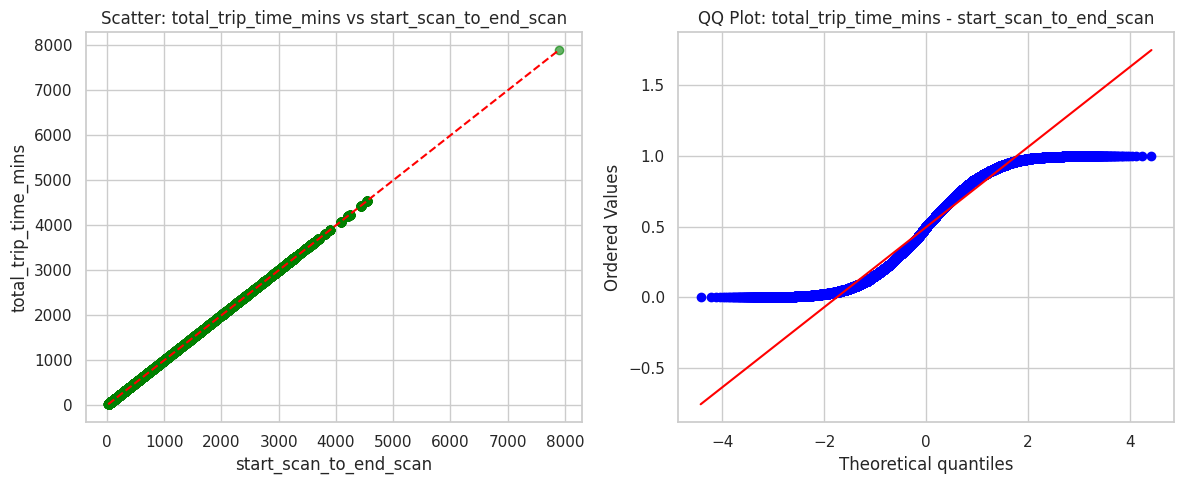


Normality test used: D’Agostino–Pearson
Statistic = 146669.6066, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [482]:
# Visual check
sns.set_theme(style="whitegrid", palette="Set2")
compare_paired_side_by_side(df_org_copy, 'total_trip_time_mins', 'start_scan_to_end_scan', alpha=0.05)

After visual analysis of QQ plot we found that differences are not normally distributed therefore, Use Wilcoxon signed-rank test

In [483]:
# Hypothesis testing - Wilcoxon signed-rank test

Hypotheses:

H₀ (Null): There’s no significant difference between the two time measures (mean diff = 0).

H₁ (Alternative): There is a difference between total_trip_time_mins and start_scan_to_end_scan(mean diff ≠ 0).

In [484]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_org_copy['total_trip_time_mins'], df_org_copy['start_scan_to_end_scan'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a difference between total_trip_time_mins and start_scan_to_end_scan.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")

Wilcoxon signed-rank test statistic: 0.0
P-value: 0.0
Reject the null hypothesis: There is a difference between total_trip_time_mins and start_scan_to_end_scan.


A scatter plot comparing Point a. vs. Start Scan to End Scan shows:
- A strong linear relationship, indicating high correlation.
- However, the points do not lie perfectly on the 45° line (y = x), suggesting a systematic bias — one measure tends to be consistently higher or lower.
This visual pattern supports the statistical finding: while the two measures track together, they differ in magnitude.

Conclusion:
Although Point a. and Start Scan to End Scan are strongly correlated, the Wilcoxon signed-rank test confirms a significant difference in their average values.
This implies that while both metrics reflect trip duration, they may be capturing different aspects of the trip or have methodological differences in how time is recorded.

#### **c. Do hypothesis testing/ visual analysis between actual_time aggregated value and OSRM time aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)**

#### **Checking relationship between aggregated fields**

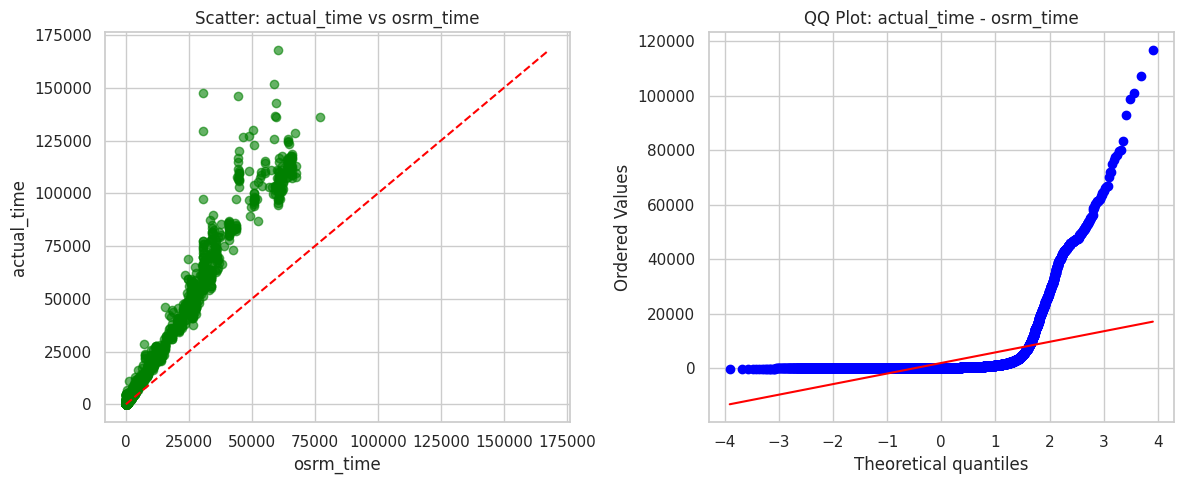


Normality test used: D’Agostino–Pearson
Statistic = 16558.5701, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [485]:
# Visual check : actual_time and osrm_time columns are aggregated columns inside df_final
sns.set_theme(style="whitegrid", palette="Set2")
compare_paired_side_by_side(df_final, 'actual_time', 'osrm_time', alpha=0.05)

After visual analysis of QQ plot we found that differences are not normally distributed therefore, Use Wilcoxon signed-rank test

In [486]:
# Hypothesis testing - Wilcoxon signed-rank test

Hypotheses:

H₀: The mean difference between actual_time and osrm_time is zero (no significant difference).

H₁: The mean difference between actual_time and osrm_time is not zero (significant difference exists).

In [487]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final['actual_time'], df_final['osrm_time'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H₀ → Significant difference between the two measurements.")
else:
    print("Fail to reject H₀ → No significant difference found.")

Wilcoxon signed-rank test statistic: 134624.0
P-value: 0.0
Reject H₀ → Significant difference between the two measurements.


**Visual Analysis:**
- The scatter plot shows a general correlation between Actual Time and OSRM Time.
- However, many data points deviate from the red reference line (Actual = OSRM), especially at higher time values.
- This indicates that OSRM tends to underestimate actual travel time, particularly for longer trips.
- When I say "underestimate", I mean that OSRM predicts a shorter time than what actually happened.


**Final Insight:**

While OSRM Time provides a useful estimate, it systematically differs from Actual Time — especially for longer durations.

This suggests that OSRM may not fully capture real-world travel conditions (e.g., traffic, delays, routing inefficiencies), and its estimates should be adjusted or calibrated for better accuracy in operational or planning contexts.


#### **d. Do hypothesis testing/ visual analysis between actual_time aggregated value and segment actual time aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)**

#### **Checking relationship between aggregated fields**

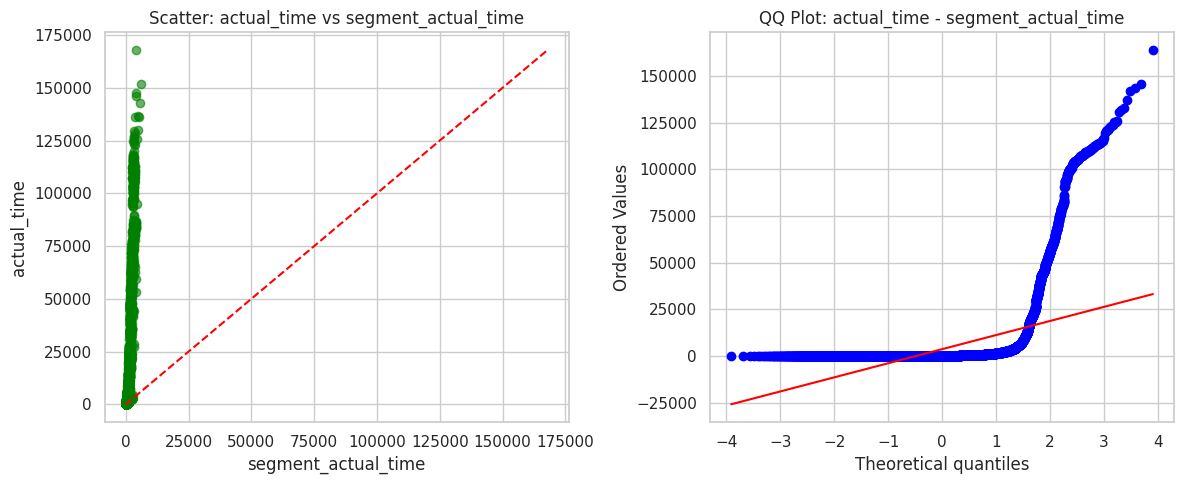


Normality test used: D’Agostino–Pearson
Statistic = 15594.2587, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [488]:
# Visual check : actualtime and segment_actual_time columns are aggregated columns inside df_final
sns.set_theme(style="whitegrid", palette="Set2")
compare_paired_side_by_side(df_final, 'actual_time', 'segment_actual_time', alpha=0.05)

After visual analysis of QQ plot we found that differences are not normally distributed therefore, Use Wilcoxon signed-rank test

In [489]:
# Hypothesis testing - Wilcoxon signed-rank test

In [490]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final['actual_time'], df_final['segment_actual_time'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H₀ → Significant difference exists between actual_time and segment_actual_time.")
else:
    print("Fail to reject H₀ → No significant difference between actual_time and segment_actual_time.")

Wilcoxon signed-rank test statistic: 0.0
P-value: 0.0
Reject H₀ → Significant difference exists between actual_time and segment_actual_time.


**Visual Analysis (Scatterplot)**
- Most data points are clustered above the red line (y = x), indicating that Segment Actual Time is consistently lower than Actual Time.
- Very few points lie near the line of equality, suggesting poor alignment between the two metrics.
- This discrepancy is especially pronounced for trips with higher actual durations.


**Final Insight:**

The analysis reveals that Segment Actual Time underrepresents the true trip duration, likely due to:
- Missing delays between segments
- Incomplete segment coverage
- Gaps in data collection or aggregation logic
This means Segment Actual Time is not a reliable proxy for Actual Time and should be used cautiously in performance metrics or operational planning. If precision is critical, consider refining the segment aggregation logic or using Actual Time directly.

#### **e. Do hypothesis testing/ visual analysis between osrm distance aggregated value and segment osrm distance aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)**

#### **Checking relationship between aggregated fields**

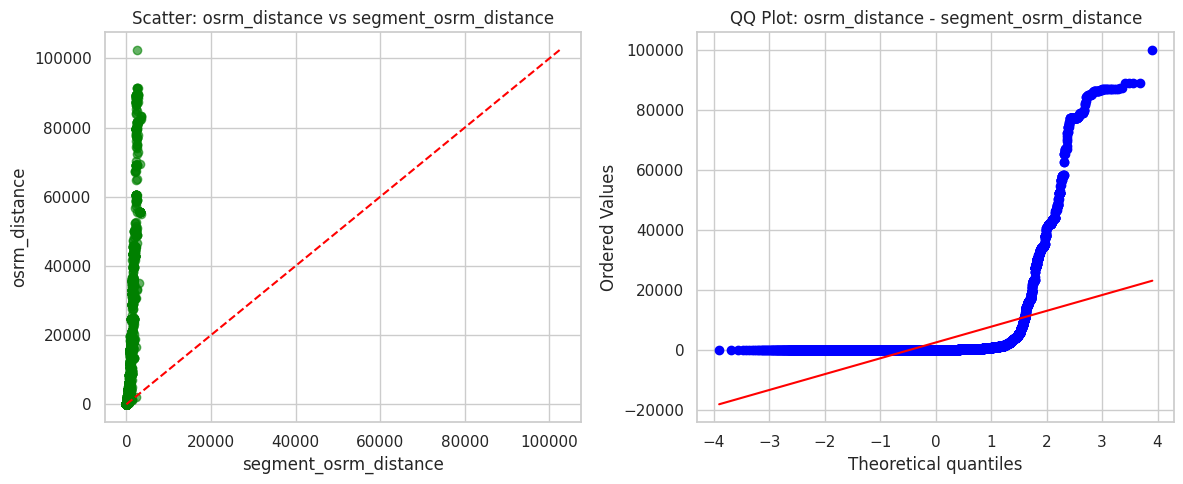


Normality test used: D’Agostino–Pearson
Statistic = 15782.9459, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [491]:
# Visual check : osrm_distance and segment_osrm_distance columns are aggregated columns inside df_final
sns.set_theme(style="whitegrid", palette="Set2")
compare_paired_side_by_side(df_final, 'osrm_distance', 'segment_osrm_distance', alpha=0.05)

After visual analysis of QQ plot we found that differences are not normally distributed therefore, Use Wilcoxon signed-rank test

In [492]:
# Hypothesis testing - Wilcoxon signed-rank test

In [493]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final['osrm_distance'], df_final['segment_osrm_distance'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H₀ → Significant difference exists between osrm_distance and segment_osrm_distance.")
else:
    print("Fail to reject H₀ → No significant difference between osrm_distance and segment_osrm_distance.")

Wilcoxon signed-rank test statistic: 26304.0
P-value: 0.0
Reject H₀ → Significant difference exists between osrm_distance and segment_osrm_distance.


**Visual Analysis (Scatterplot)**
- The majority of data points lie above the line of equality (y = x), indicating that segment_osrm_distance tends to underestimate the actual osrm_distance.

- Only a small number of points fall close to the red dashed line, suggesting a poor correlation between the two metrics. This misalignment could reflect inconsistencies in how segment distances are aggregated.

- The gap between the two metrics becomes more pronounced for longer trips, implying that the error compounds with distance.


#### **f. Do hypothesis testing/ visual analysis between osrm time aggregated value and segment osrm time aggregated value (aggregated values are the values you’ll get after merging the rows on the basis of trip_uuid)**

#### **Checking relationship between aggregated fields**

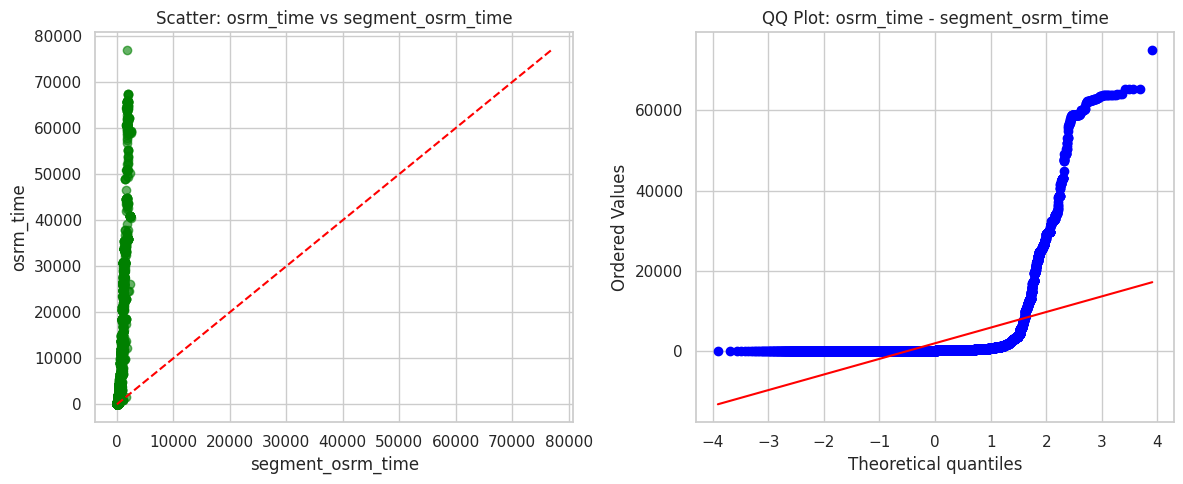


Normality test used: D’Agostino–Pearson
Statistic = 15842.3538, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [494]:
# Visual check : Aggregated osrm_time and segment_osrm_time columns are aggregated columns inside df_final
sns.set_theme(style="whitegrid", palette="Set2")
compare_paired_side_by_side(df_final, 'osrm_time', 'segment_osrm_time', alpha=0.05)

After visual analysis of QQ plot we found that differences are not normally distributed therefore, Use Wilcoxon signed-rank test

In [495]:
# Hypothesis testing - Wilcoxon signed-rank test

In [496]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final['osrm_time'], df_final['segment_osrm_time'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject H₀ → Significant difference exists between osrm_time and segment_osrm_time.")
else:
    print("Fail to reject H₀ → No significant difference between osrm_time and segment_osrm_time.")

Wilcoxon signed-rank test statistic: 21161.5
P-value: 0.0
Reject H₀ → Significant difference exists between osrm_time and segment_osrm_time.


**Visual Analysis (Scatterplot)**
- Vertical clustering near the Y-axis –
Most points are concentrated where segment_osrm_time is very small, but osrm_time is very large.
This indicates that at the segment level, estimated times are small, but when aggregated to the full route, total OSRM times become disproportionately high.

- Deviation from the red reference line (ideal 1:1 relationship) –
The majority of points lie far above the diagonal line, meaning osrm_time is significantly greater than segment_osrm_time in most cases.
This could suggest overestimation in route-level times or underestimation in segment-level times.

#### **g. Find outliers in the numerical variables (you might find outliers in almost all the variables), and check it using visual analysis**

In [497]:
# Outlier detection using IQR
# List of columns to check for outliers
numerical_columns = [
    "start_scan_to_end_scan",
    "cutoff_factor",
    "actual_distance_to_destination",
    "actual_time",
    "osrm_time",
    "osrm_distance",
    "factor",
    "segment_actual_time",
    "segment_osrm_time",
    "segment_osrm_distance",
    "segment_factor"
]
outliers_dict = {}
bold_start = "\033[1m"
bold_end = "\033[0m"
for col in numerical_columns:
    if col in df_final.columns:
        Q1 = df_final[col].quantile(0.25)
        Q3 = df_final[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Boolean mask for outliers
        outliers = df_final[(df_final[col] < lower_bound) | (df_final[col] > upper_bound)]

        outliers_dict[col] = outliers

        print(f"{bold_start}{col}{bold_end}: {len(outliers)} outliers found")
    else:
        print(f"Column {bold_start}'{col}'{bold_end} not found in DataFrame")

start_scan_to_end_scan: 2026 outliers found
cutoff_factor: 2031 outliers found
actual_distance_to_destination: 2122 outliers found
actual_time: 2070 outliers found
osrm_time: 1948 outliers found
osrm_distance: 2069 outliers found
factor: 1205 outliers found
segment_actual_time: 1643 outliers found
segment_osrm_time: 1492 outliers found
segment_osrm_distance: 1548 outliers found
segment_factor: 1344 outliers found


Visual check using boxplot

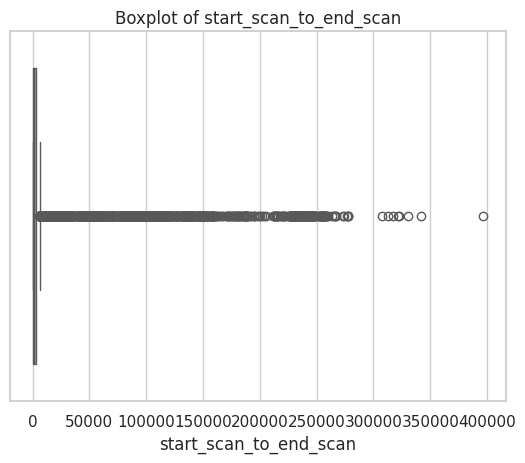

In [498]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='start_scan_to_end_scan', data=df_final)
plt.title("Boxplot of start_scan_to_end_scan")
plt.show()

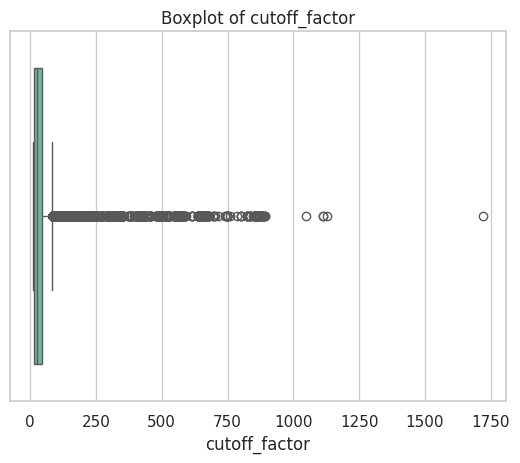

In [499]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='cutoff_factor', data=df_final)
plt.title("Boxplot of cutoff_factor")
plt.show()

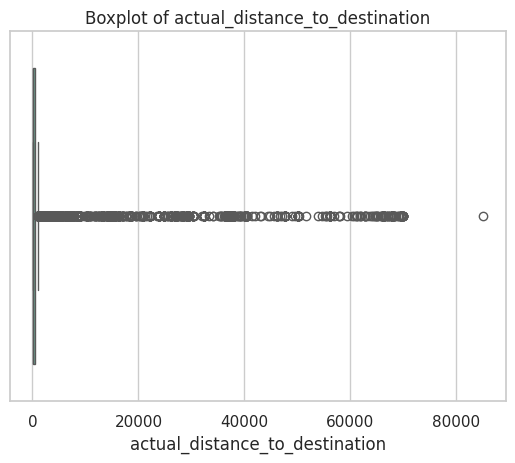

In [500]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='actual_distance_to_destination', data=df_final)
plt.title("Boxplot of actual_distance_to_destination")
plt.show()

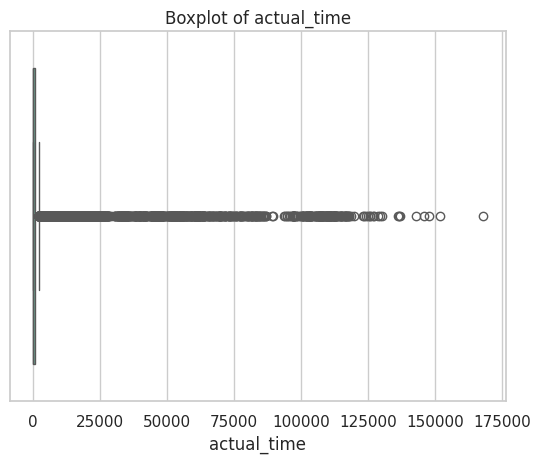

In [501]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='actual_time', data=df_final)
plt.title("Boxplot of actual_time")
plt.show()

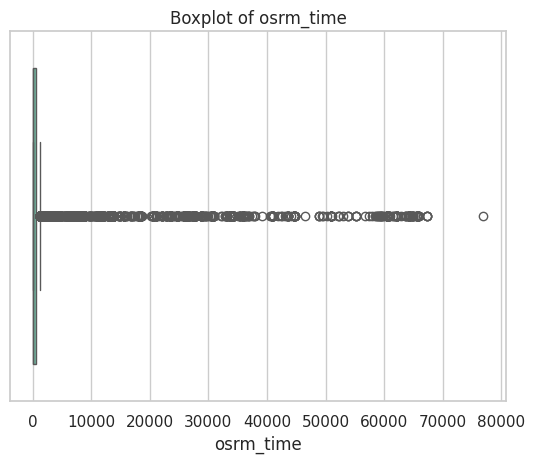

In [502]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='osrm_time', data=df_final)
plt.title("Boxplot of osrm_time")
plt.show()

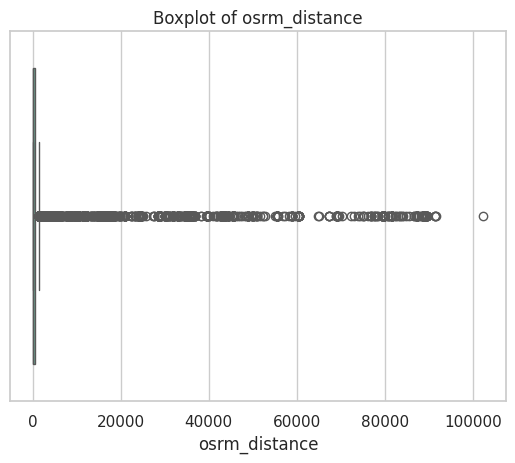

In [503]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='osrm_distance', data=df_final)
plt.title("Boxplot of osrm_distance")
plt.show()

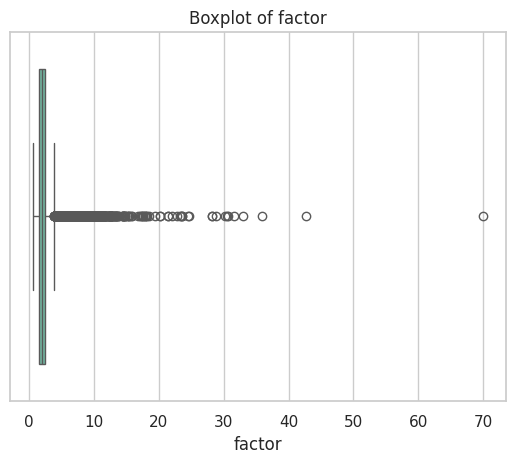

In [504]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='factor', data=df_final)
plt.title("Boxplot of factor")
plt.show()

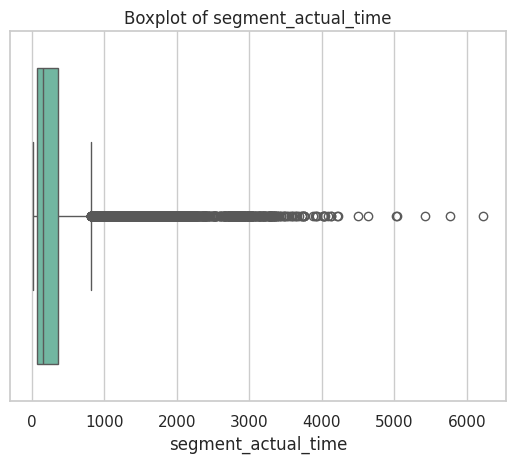

In [505]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_actual_time', data=df_final)
plt.title("Boxplot of segment_actual_time")
plt.show()

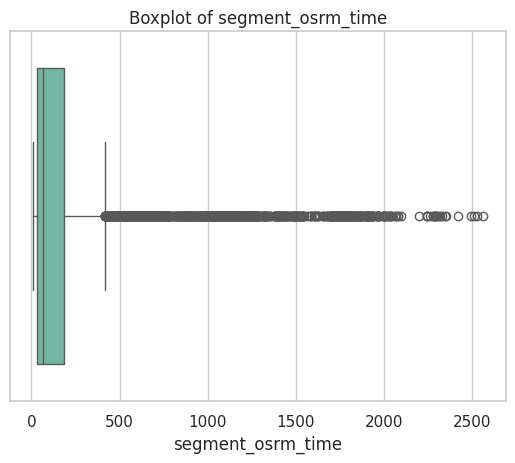

In [506]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_osrm_time', data=df_final)
plt.title("Boxplot of segment_osrm_time")
plt.show()

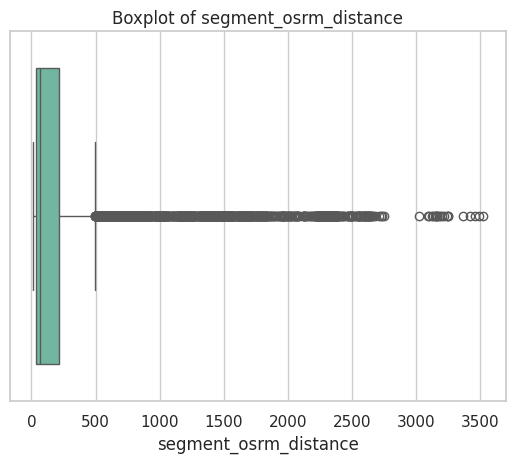

In [507]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_osrm_distance', data=df_final)
plt.title("Boxplot of segment_osrm_distance")
plt.show()

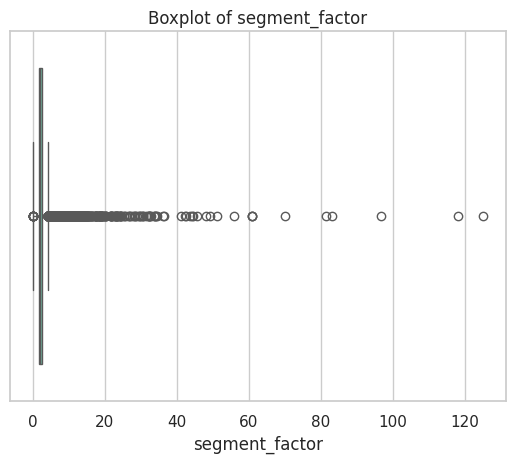

In [508]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_factor', data=df_final)
plt.title("Boxplot of segment_factor")
plt.show()

#### **h. Handle the outliers using the IQR method. Outlier treatment**

In [509]:
# Make a copy so original DF stays unchanged
df_final_iqr = df_final.copy()

for col in numerical_columns:
    Q1 = df_final_iqr[col].quantile(0.25)
    Q3 = df_final_iqr[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values in-place
    df_final_iqr[col] = np.clip(df_final_iqr[col], lower_bound, upper_bound)

In [510]:
df_final_iqr.shape

(14817, 35)

This shows we have retained all the rows, just it is a capped version of featured dataframe

Visual check after capping the outliers

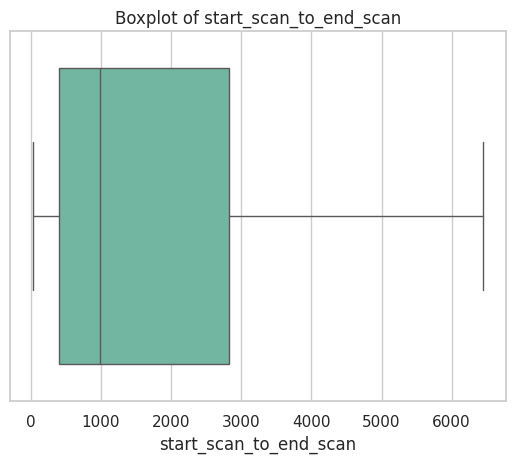

In [511]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='start_scan_to_end_scan', data=df_final_iqr)
plt.title("Boxplot of start_scan_to_end_scan")
plt.show()

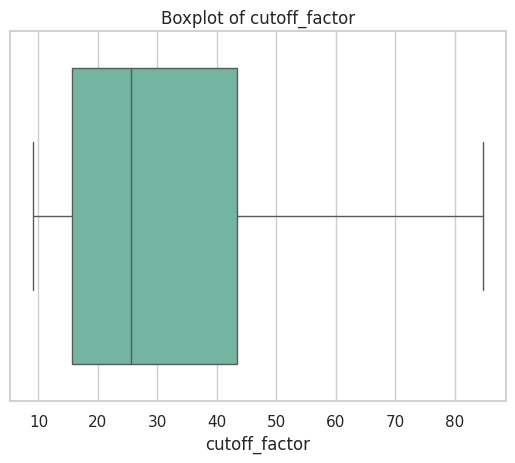

In [512]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='cutoff_factor', data=df_final_iqr)
plt.title("Boxplot of cutoff_factor")
plt.show()

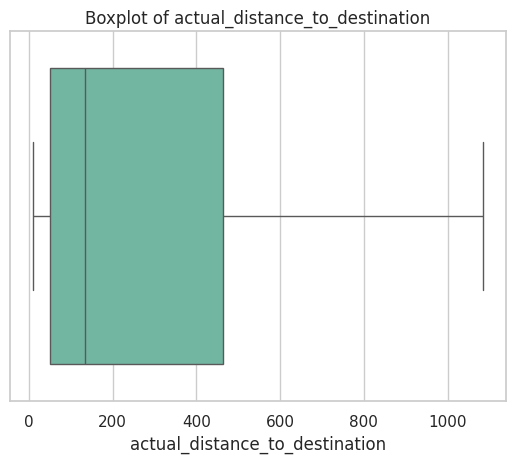

In [513]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='actual_distance_to_destination', data=df_final_iqr)
plt.title("Boxplot of actual_distance_to_destination")
plt.show()

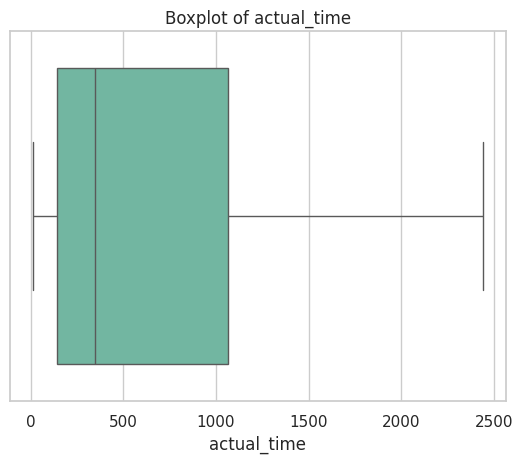

In [514]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='actual_time', data=df_final_iqr)
plt.title("Boxplot of actual_time")
plt.show()

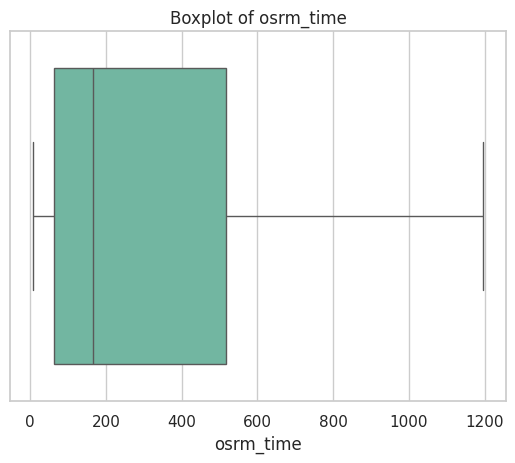

In [515]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='osrm_time', data=df_final_iqr)
plt.title("Boxplot of osrm_time")
plt.show()

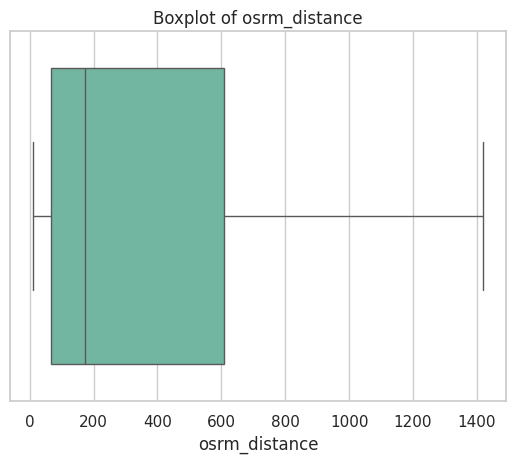

In [516]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='osrm_distance', data=df_final_iqr)
plt.title("Boxplot of osrm_distance")
plt.show()

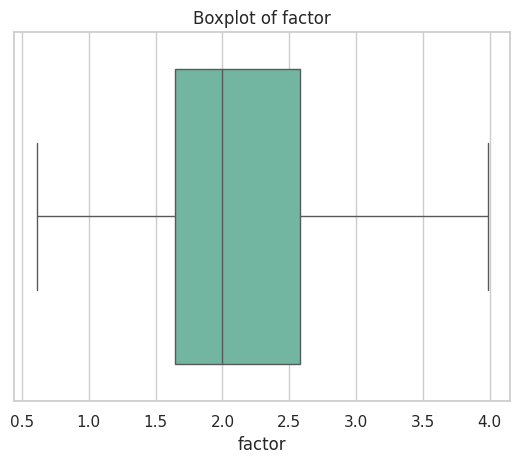

In [517]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='factor', data=df_final_iqr)
plt.title("Boxplot of factor")
plt.show()

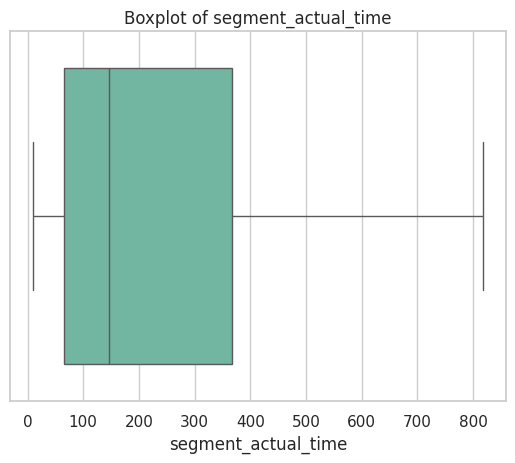

In [518]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_actual_time', data=df_final_iqr)
plt.title("Boxplot of segment_actual_time")
plt.show()

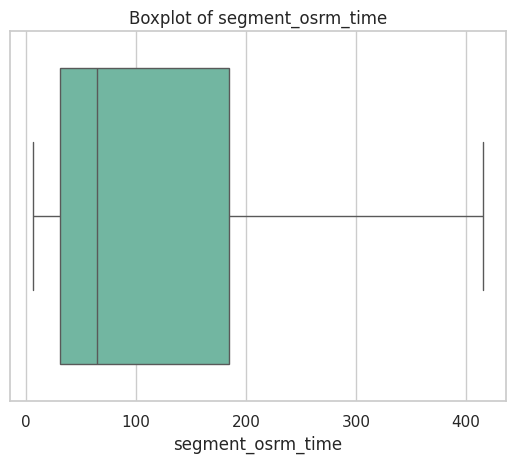

In [519]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_osrm_time', data=df_final_iqr)
plt.title("Boxplot of segment_osrm_time")
plt.show()

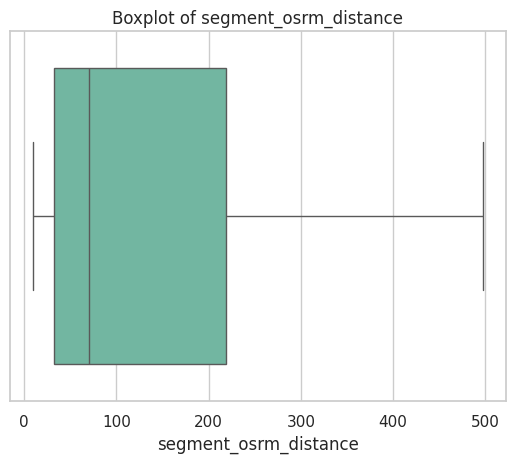

In [520]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_osrm_distance', data=df_final_iqr)
plt.title("Boxplot of segment_osrm_distance")
plt.show()

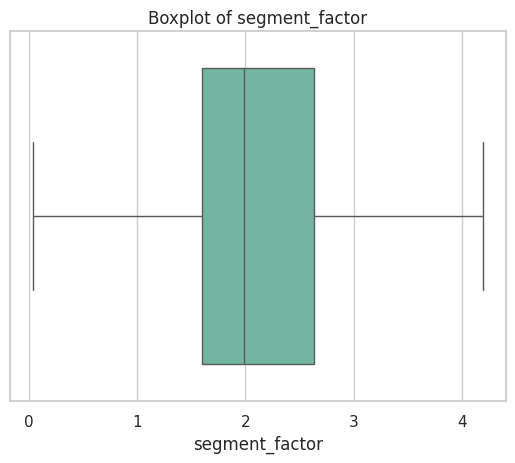

In [521]:
sns.set_theme(style="whitegrid", palette="Set2")
sns.boxplot(x='segment_factor', data=df_final_iqr)
plt.title("Boxplot of segment_factor")
plt.show()

**Checking relationship between aggregated fields using hypothesis testing (after an outlier treatment)**

In [522]:
# Calculate time taken
df_final_iqr['total_trip_time'] = df_final_iqr['od_end_time'] - df_final_iqr['od_start_time']

# In minutes
df_final_iqr['total_trip_time_mins'] = df_final_iqr['total_trip_time'].dt.total_seconds() / 60
df_final_iqr[['od_start_time', 'od_end_time', 'total_trip_time_mins']]

,od_start_time,od_end_time,total_trip_time_mins
0,2018-09-20 03:21:32.418600,2018-09-20 06:36:55.627764,195.386819
1,2018-09-23 06:42:06.021680,2018-09-23 11:44:28.365845,302.372403
2,2018-09-14 15:42:46.437249,2018-09-14 17:31:45.368791,108.982192
3,2018-09-13 20:44:19.424489,2018-09-14 13:55:58.765334,1031.655681
4,2018-09-30 02:22:04.138164,2018-09-30 06:44:42.320422,262.636371
...,...,...,...
14812,2018-09-27 02:48:14.315366,2018-09-27 17:18:35.292509,870.349619
14813,2018-09-14 18:45:34.164734,2018-09-15 01:19:26.775457,393.876845
14814,2018-09-22 11:30:41.399439,2018-09-22 21:45:05.128533,614.395485
14815,2018-09-17 11:35:28.838714,2018-09-17 13:32:21.128357,116.871494


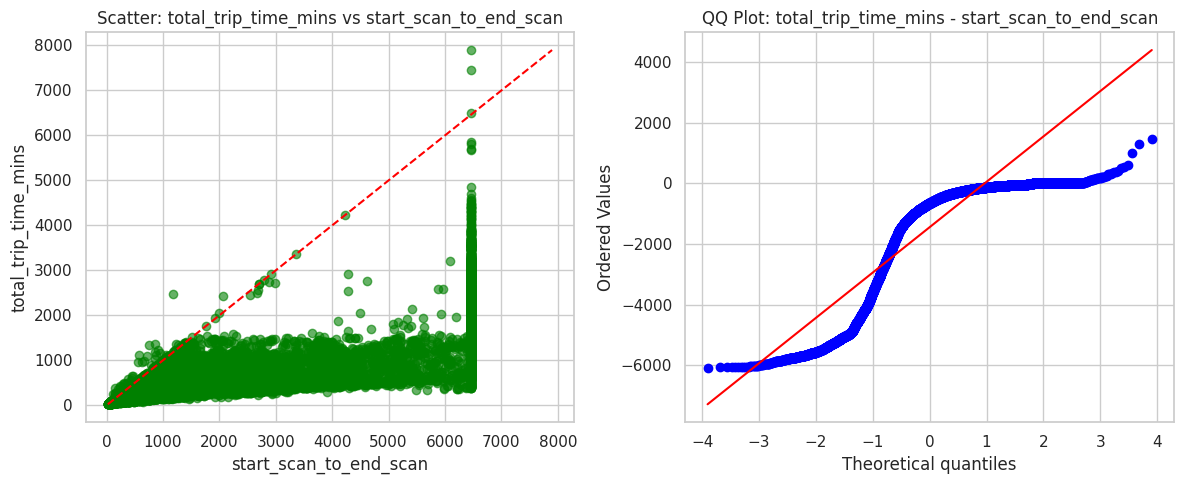


Normality test used: D’Agostino–Pearson
Statistic = 2529.0910, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [523]:
# Visual check between total_trip_time_mins and start_scan_to_end_scan after an outlier treatment
compare_paired_side_by_side(df_final_iqr, 'total_trip_time_mins', 'start_scan_to_end_scan', alpha=0.05)

In [524]:
# Hypothesis testing - Wilcoxon signed-rank test

In [525]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final_iqr['total_trip_time_mins'], df_final_iqr['start_scan_to_end_scan'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a difference between total_trip_time_mins and start_scan_to_end_scan.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")

Wilcoxon signed-rank test statistic: 266093.0
P-value: 0.0
Reject the null hypothesis: There is a difference between total_trip_time_mins and start_scan_to_end_scan.


Even after outlier treatment there is no change in the hypothesis test result.

Conclusion: There is a difference between total_trip_time_mins and start_scan_to_end_scan

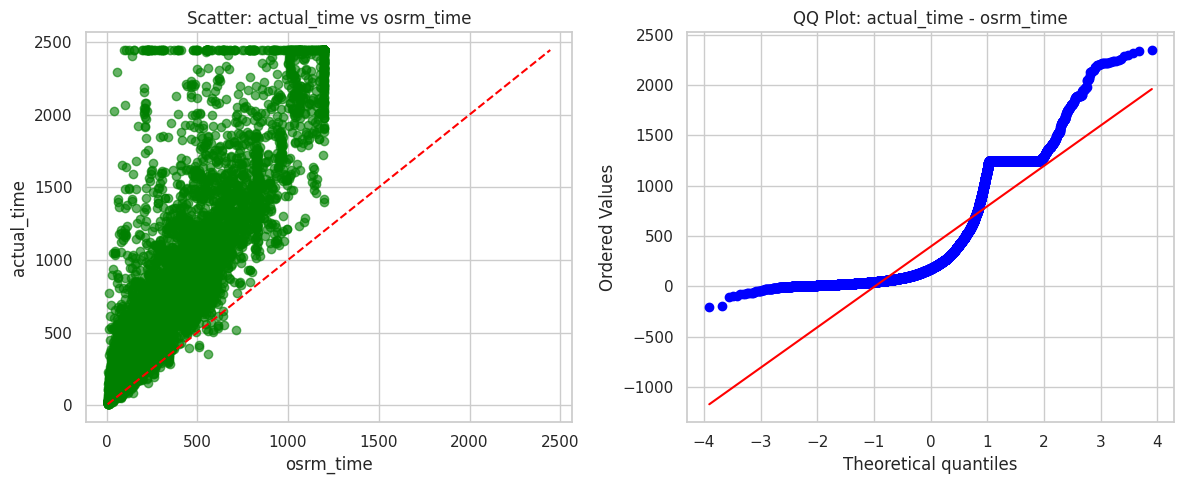


Normality test used: D’Agostino–Pearson
Statistic = 2718.8536, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [526]:
# Visual check between actual_time and osrm_time after an outlier treatment
compare_paired_side_by_side(df_final_iqr, 'actual_time', 'osrm_time', alpha=0.05)

In [527]:
# Hypothesis testing - Wilcoxon signed-rank test

In [528]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final_iqr['actual_time'], df_final_iqr['osrm_time'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a difference between actual_time and osrm_time.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")

Wilcoxon signed-rank test statistic: 134581.0
P-value: 0.0
Reject the null hypothesis: There is a difference between actual_time and osrm_time.


**Comments:**

Even after outlier treatment there is no change in the hypothesis test result.

Conclusion: There is a difference between actual_time and osrm_time

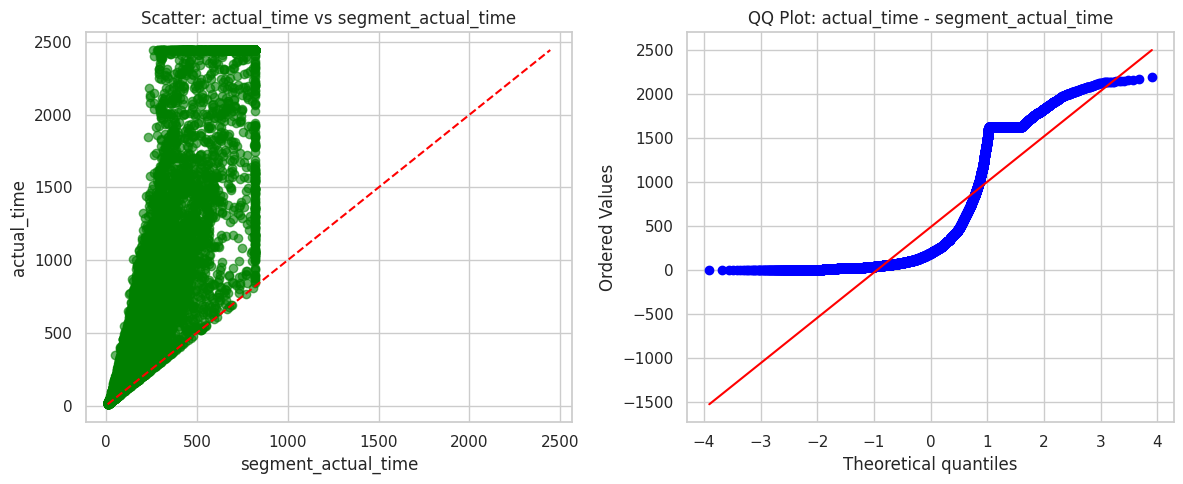


Normality test used: D’Agostino–Pearson
Statistic = 2453.1991, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [529]:
# Visual check between actual_time and segment_actual_time after an outlier treatment
compare_paired_side_by_side(df_final_iqr, 'actual_time', 'segment_actual_time', alpha=0.05)

In [530]:
# Hypothesis testing - Wilcoxon signed-rank test

In [531]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final_iqr['actual_time'], df_final_iqr['segment_actual_time'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a difference between actual_time and segment_actual_time.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")

Wilcoxon signed-rank test statistic: 0.0
P-value: 0.0
Reject the null hypothesis: There is a difference between actual_time and segment_actual_time.


**Comments:**

Even after outlier treatment there is no change in the hypothesis test result.

Conclusion: There is a difference between actual_time and segment_actual_time

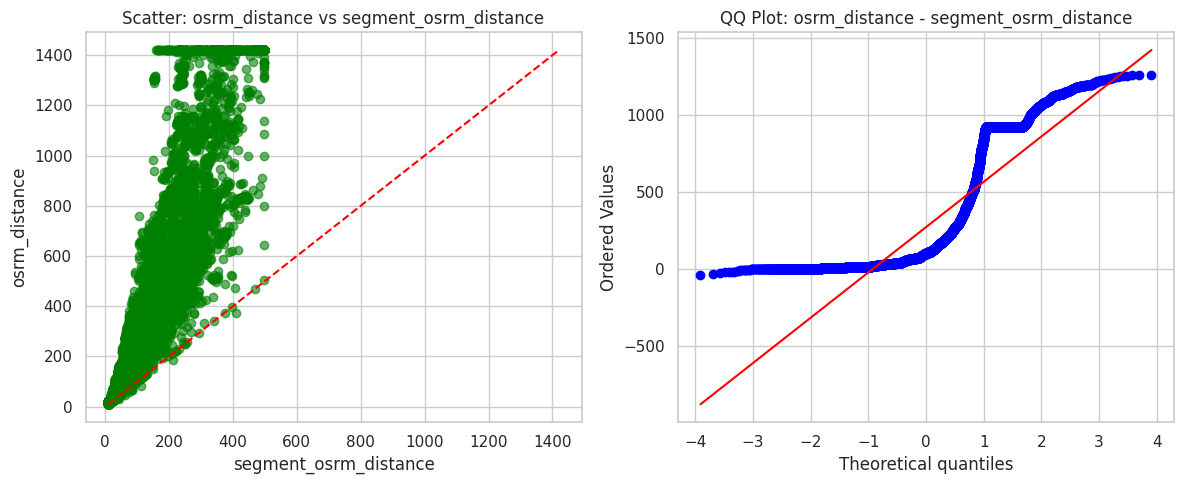


Normality test used: D’Agostino–Pearson
Statistic = 2508.6395, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [532]:
# Visual check between osrm_distance and segment_osrm_distance after an outlier treatment
compare_paired_side_by_side(df_final_iqr, 'osrm_distance', 'segment_osrm_distance', alpha=0.05)

In [533]:
# Hypothesis testing - Wilcoxon signed-rank test

In [534]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final_iqr['osrm_distance'], df_final_iqr['segment_osrm_distance'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a difference between osrm_distance and segment_osrm_distance.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")

Wilcoxon signed-rank test statistic: 21619.0
P-value: 0.0
Reject the null hypothesis: There is a difference between osrm_distance and segment_osrm_distance.


**Comments:**

Even after outlier treatment there is no change in the hypothesis test result.

Conclusion: There is a difference between osrm_distance and segment_osrm_distance

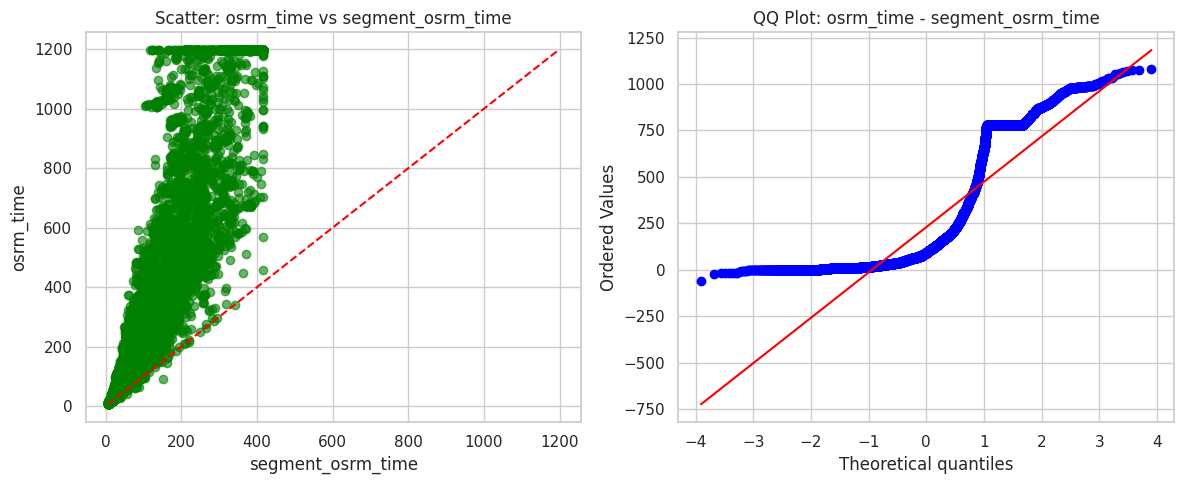


Normality test used: D’Agostino–Pearson
Statistic = 2555.3271, p-value = 0.0000
Differences are not normally distributed → Use Wilcoxon signed-rank test.


In [535]:
# Visual check between osrm_time and segment_osrm_time after an outlier treatment
compare_paired_side_by_side(df_final_iqr, 'osrm_time', 'segment_osrm_time', alpha=0.05)

In [536]:
# Hypothesis testing - Wilcoxon signed-rank test

In [537]:
from scipy.stats import wilcoxon

# Run Wilcoxon signed-rank test
stat, p_value = wilcoxon(df_final_iqr['osrm_time'], df_final_iqr['segment_osrm_time'])

print(f"Wilcoxon signed-rank test statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a difference between osrm_time and segment_osrm_time.")
else:
    print("Fail to reject the null hypothesis: No significant difference detected.")

Wilcoxon signed-rank test statistic: 21161.5
P-value: 0.0
Reject the null hypothesis: There is a difference between osrm_time and segment_osrm_time.


**Comments:**

Even after outlier treatment there is no change in the hypothesis test result.

Conclusion: There is a difference between osrm_time and segment_osrm_time

#### **i. Do one-hot encoding of categorical variables (like route_type)**

#### **Handling categorical values**

In [538]:
# One-hot encoding for multiple categorical columns
categorical_cols = ['data', 'route_type', 'is_cutoff']

df_final_iqr_one_hot = pd.get_dummies(
    df_final_iqr,
    columns=categorical_cols,
    dtype=int  # Ensures 0/1 are integers
)

df_final_iqr_one_hot

,trip_uuid,trip_creation_time,year,month,day,route_schedule_uuid,source_center,source_name,source_city,source_place,...,segment_osrm_distance,segment_factor,total_trip_time,total_trip_time_mins,data_test,data_training,route_type_Carting,route_type_FTL,is_cutoff_False,is_cutoff_True
0,trip-153741093647649320,2018-09-20 02:35:36.476840,2018,9,20,thanos::sroute:eb7bfc78-b351-4c0e-a951-fa3d5c3...,IND388121AAA,Anand_VUNagar_DC (Gujarat),Anand,VUNagar,...,102.71060,2.089228,0 days 03:15:23.209164,195.386819,0,1,1,0,0,1
1,trip-153768492602129387,2018-09-23 06:42:06.021680,2018,9,23,thanos::sroute:ff52ef7a-4d0d-4063-9bfe-cc21172...,IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),Bhiwandi,Mankoli,...,130.40890,1.781363,0 days 05:02:22.344165,302.372403,0,1,0,1,0,1
2,trip-153693976643699843,2018-09-14 15:42:46.437249,2018,9,14,thanos::sroute:a16bfa03-3462-4bce-9c82-5784c7d...,IND400011AAA,LowerParel_CP (Maharashtra),LowerParel,unknown_source_place,...,18.79410,3.490909,0 days 01:48:58.931542,108.982192,0,1,1,0,1,0
3,trip-153687145942424248,2018-09-13 20:44:19.424489,2018,9,13,thanos::sroute:76951383-1608-44e4-a284-46d92e8...,IND562132AAA,Bangalore_Nelmngla_H (Karnataka),Bangalore,Nelmngla,...,498.02425,1.422855,0 days 17:11:39.340845,1031.655681,0,1,0,1,1,0
4,trip-153825970514894360,2018-09-29 22:21:45.149226,2018,9,29,thanos::sroute:0904e75c-b3ac-4278-96cf-802835a...,IND141003AAB,Ludhiana_GillChwk_DC (Punjab),Ludhiana,GillChwk,...,115.75010,1.195547,0 days 04:22:38.182258,262.636371,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14812,trip-153799142965708367,2018-09-26 19:50:29.657378,2018,9,26,thanos::sroute:f6d1ba62-76a2-4dba-83ec-3ac0803...,IND454001AAA,Dhar_Trimurti_D (Madhya Pradesh),Dhar,Trimurti,...,498.02425,1.213298,0 days 14:30:20.977143,870.349619,0,1,0,1,0,1
14813,trip-153695073416451616,2018-09-14 18:45:34.164734,2018,9,14,thanos::sroute:40b6dc9c-faa1-4753-8bc8-ac8c3e0...,IND400102AAB,Mumbai_Jogeshwri_L (Maharashtra),Mumbai,Jogeshwri,...,40.13600,4.200008,0 days 06:33:52.610723,393.876845,0,1,1,0,1,0
14814,trip-153761584139918815,2018-09-22 11:30:41.399439,2018,9,22,thanos::sroute:d81088e2-9ccd-43e9-9260-3e85633...,IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),Bhiwandi,Mankoli,...,129.34120,3.121489,0 days 10:14:23.729094,614.395485,0,1,0,1,0,1
14815,trip-153718412883843340,2018-09-17 11:35:28.838714,2018,9,17,thanos::sroute:d8f74492-4484-412a-887a-61c8e6b...,IND600056AAB,MAA_Poonamallee_HB (Tamil Nadu),MAA,Poonamallee,...,36.76710,2.531250,0 days 01:56:52.289643,116.871494,0,1,1,0,0,1


#### **j. Normalize/ Standardize the numerical features using MinMaxScaler or StandardScaler.**

#### **Column Normalization /Column Standardization**

In [539]:
def analyze_numeric_columns(df, numeric_cols):
    stats = df[numeric_cols].describe().T
    stats['skewness'] = df[numeric_cols].skew()

    print("Summary statistics and skewness:")
    print(stats)
analyze_numeric_columns(df_final_iqr_one_hot, ['start_scan_to_end_scan', 'cutoff_factor', 'actual_distance_to_destination',
                                       'actual_time', 'osrm_time','osrm_distance','factor','segment_actual_time','segment_osrm_time',
                                       'segment_osrm_distance','segment_factor'])

Summary statistics and skewness:
                                  count         mean          std        min  \
start_scan_to_end_scan          14817.0  1994.321320  2170.263007  26.000000   
cutoff_factor                   14817.0    34.368513    24.828515   9.000000   
actual_distance_to_destination  14817.0   325.977962   374.508492   9.002461   
actual_time                     14817.0   748.781602   827.770821   9.000000   
osrm_time                       14817.0   355.680570   400.609264   6.000000   
osrm_distance                   14817.0   419.593398   485.128700   9.072900   
factor                          14817.0     2.210578     0.796138   0.610398   
segment_actual_time             14817.0   261.573699   259.133886   9.000000   
segment_osrm_time               14817.0   126.123844   128.453228   6.000000   
segment_osrm_distance           14817.0   146.940017   155.186921   9.072900   
segment_factor                  14817.0     2.215180     0.928665   0.031480   

      

In [540]:
def analyze_numeric_columns(df, col):
    # Plot histograms and boxplots to visually check distributions and outliers
        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        sns.histplot(df[col], kde=True)
        plt.title(f"Histogram and KDE of {col}")

        plt.subplot(1,2,2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")

        plt.show()

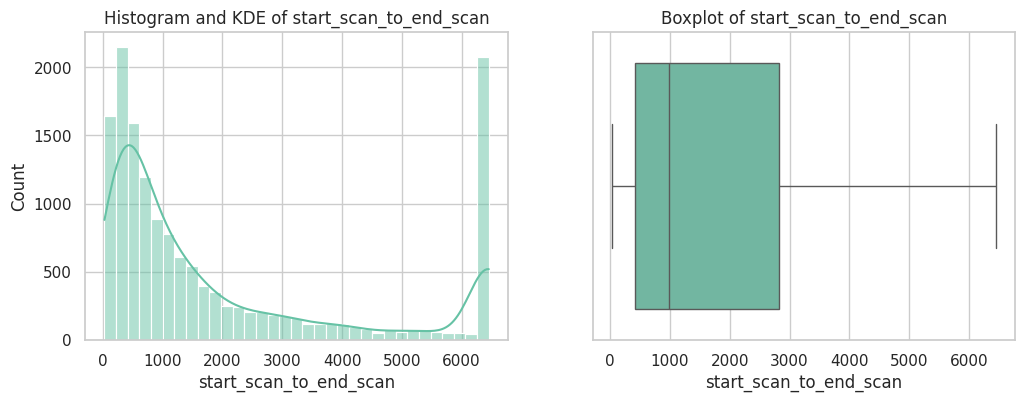

In [541]:
analyze_numeric_columns(df_final_iqr_one_hot, 'start_scan_to_end_scan')


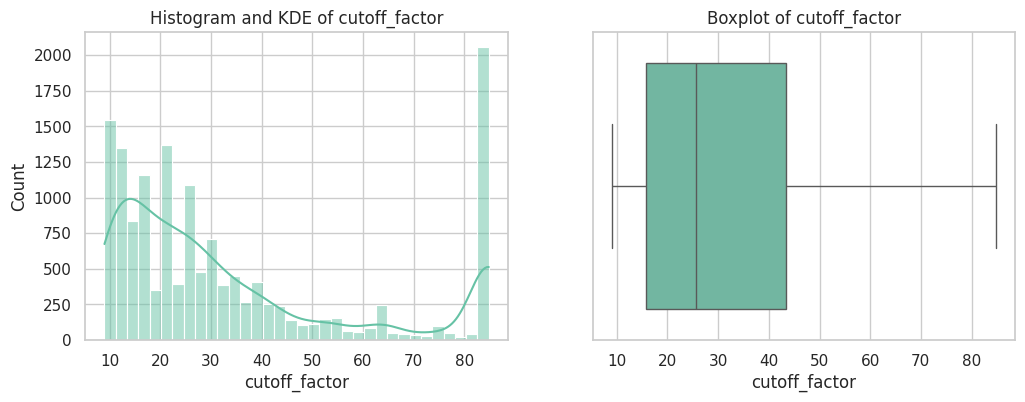

In [542]:
analyze_numeric_columns(df_final_iqr_one_hot, 'cutoff_factor')

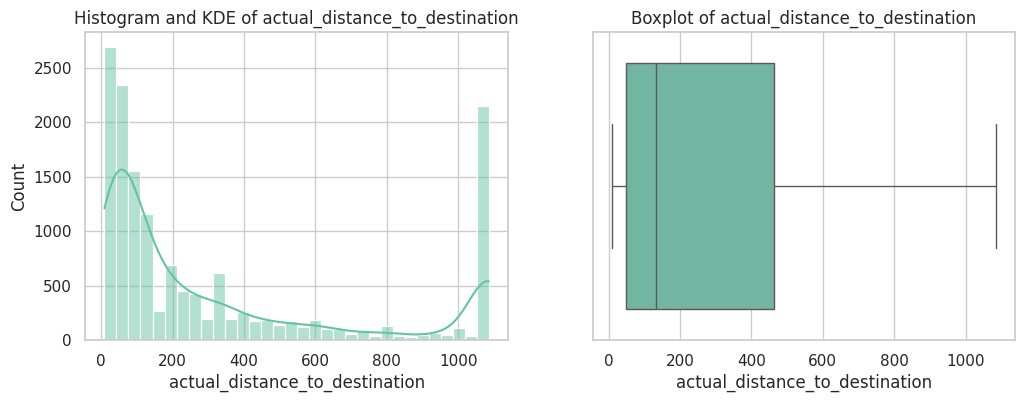

In [543]:
analyze_numeric_columns(df_final_iqr_one_hot, 'actual_distance_to_destination')

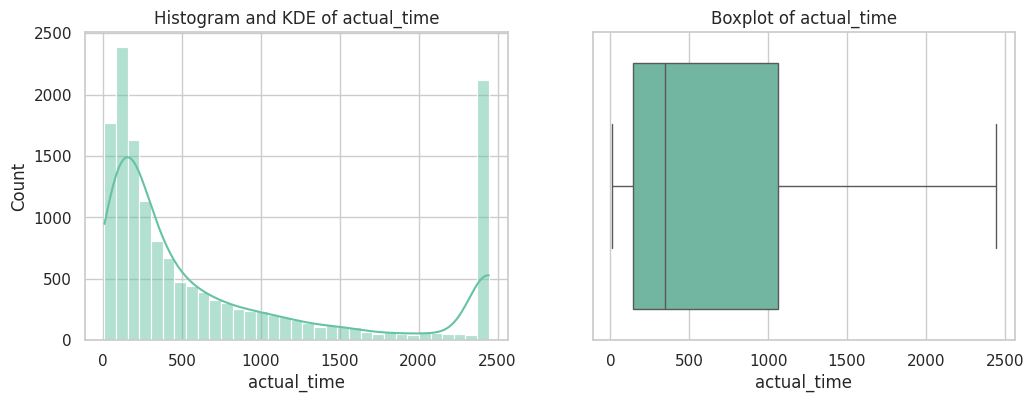

In [544]:
analyze_numeric_columns(df_final_iqr_one_hot, 'actual_time')

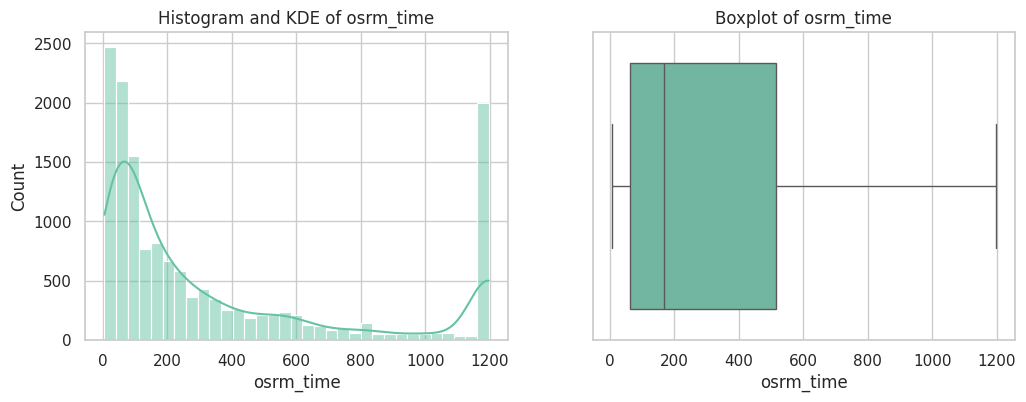

In [545]:
analyze_numeric_columns(df_final_iqr_one_hot, 'osrm_time')

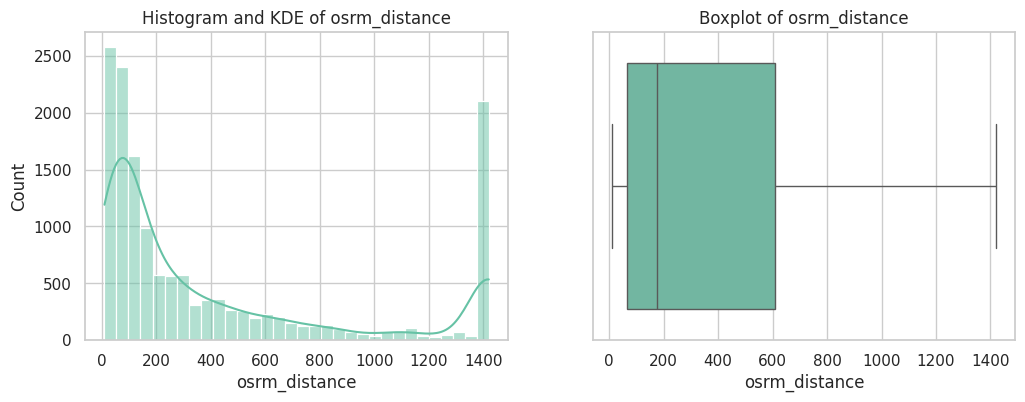

In [546]:
analyze_numeric_columns(df_final_iqr_one_hot, 'osrm_distance')

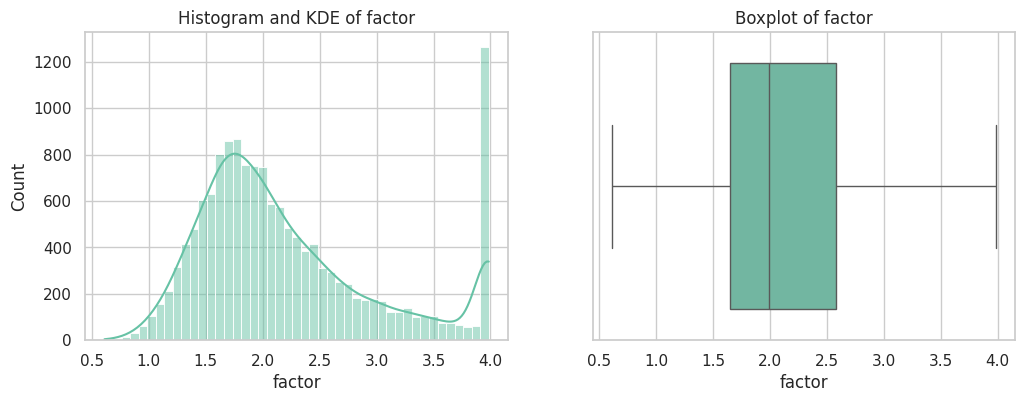

In [547]:
analyze_numeric_columns(df_final_iqr_one_hot, 'factor')

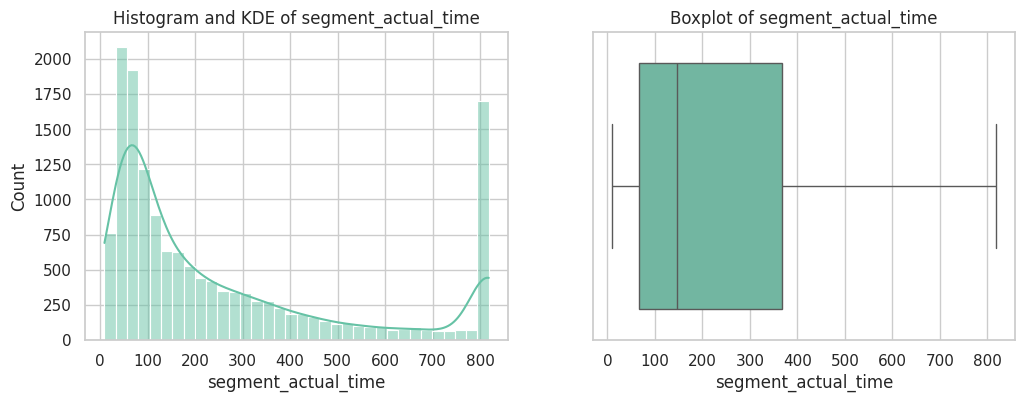

In [548]:
analyze_numeric_columns(df_final_iqr_one_hot, 'segment_actual_time')

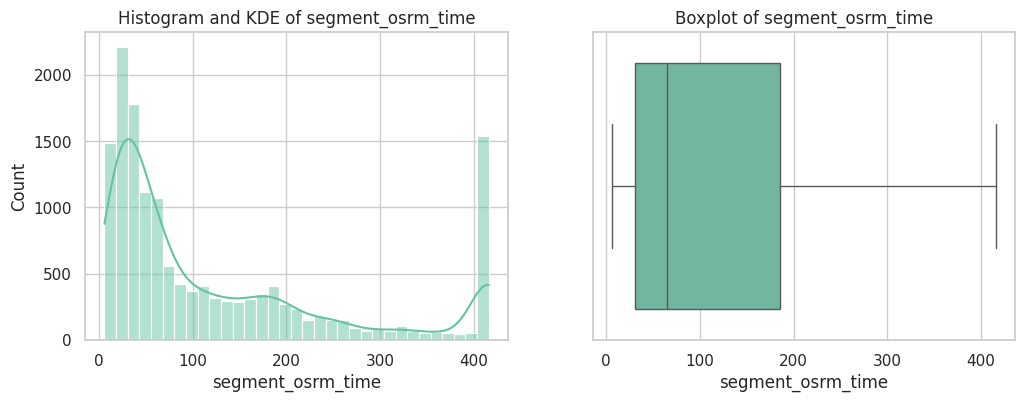

In [549]:
analyze_numeric_columns(df_final_iqr_one_hot, 'segment_osrm_time')

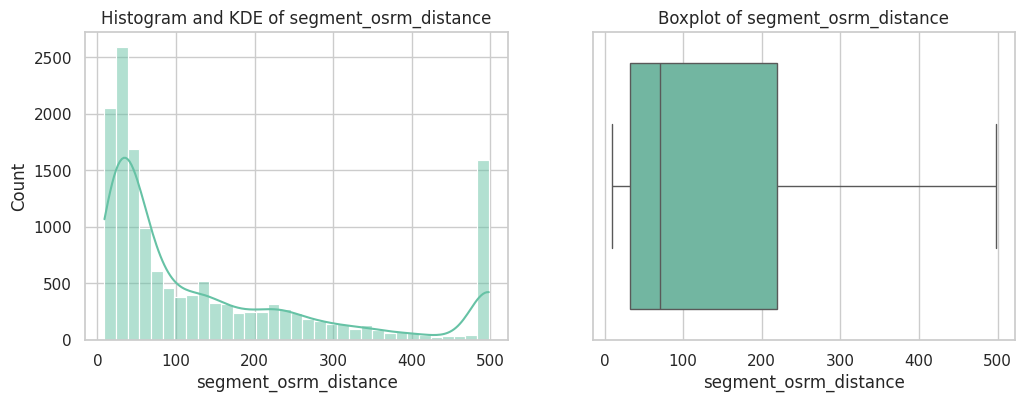

In [550]:
analyze_numeric_columns(df_final_iqr_one_hot, 'segment_osrm_distance')

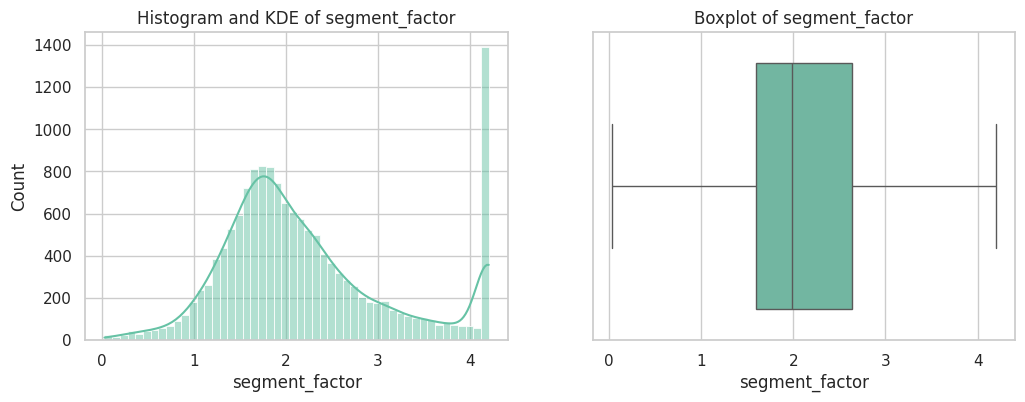

In [551]:
analyze_numeric_columns(df_final_iqr_one_hot, 'segment_factor')

In [552]:
# Basic decision guidance
print("\nGuidance based on skewness and outliers:")
for col in numerical_columns:
  skew = df_final_iqr_one_hot[col].skew()
  q1 = df_final_iqr_one_hot[col].quantile(0.25)
  q3 = df_final_iqr_one_hot[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  outliers = df_final_iqr_one_hot[(df_final_iqr_one_hot[col] < lower_bound) | (df_final_iqr_one_hot[col] > upper_bound)][col]
  outlier_pct = len(outliers) / len(df_final_iqr_one_hot) * 100

  print(f"{col}: Skewness={skew:.2f}, Outliers={outlier_pct:.2f}%")
  if abs(skew) < 0.5 and outlier_pct < 5:
    print(f"  -> Likely StandardScaler is suitable")
  else:
    print(f"  -> MinMaxScaler might be better due to skew/outliers\n")



Guidance based on skewness and outliers:
start_scan_to_end_scan: Skewness=1.19, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

cutoff_factor: Skewness=1.08, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

actual_distance_to_destination: Skewness=1.18, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

actual_time: Skewness=1.19, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

osrm_time: Skewness=1.22, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

osrm_distance: Skewness=1.21, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

factor: Skewness=0.93, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

segment_actual_time: Skewness=1.17, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

segment_osrm_time: Skewness=1.24, Outliers=0.00%
  -> MinMaxScaler might be better due to skew/outliers

segment_osrm_distance: Ske

**The analysis recommends MinMaxScaler**

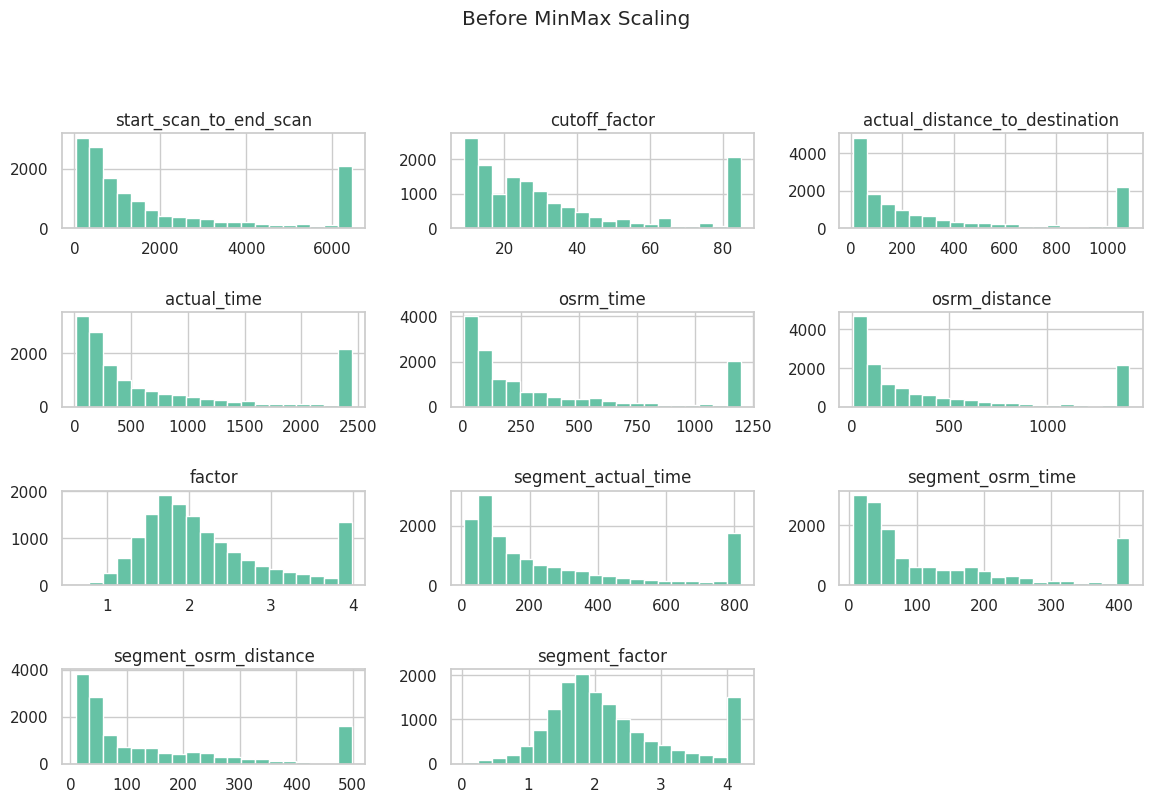

In [553]:
# Before MinMax scaling
sns.set_theme(style="whitegrid", palette="Set2")
df_final_iqr_one_hot[numerical_columns].hist(figsize=(12, 8), bins=20)
plt.suptitle("Before MinMax Scaling", y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

In [554]:
# Using MinMax scaling
df_scaled = df_final_iqr_one_hot.copy()

scaler = MinMaxScaler()
df_scaled[numerical_columns] = scaler.fit_transform(df_scaled[numerical_columns])

In [555]:
df_scaled[numerical_columns].min()

,0
start_scan_to_end_scan,0.0
cutoff_factor,0.0
actual_distance_to_destination,0.0
actual_time,0.0
osrm_time,0.0
osrm_distance,0.0
factor,0.0
segment_actual_time,0.0
segment_osrm_time,0.0
segment_osrm_distance,0.0


In [556]:
df_scaled[numerical_columns].max()

,0
start_scan_to_end_scan,1.0
cutoff_factor,1.0
actual_distance_to_destination,1.0
actual_time,1.0
osrm_time,1.0
osrm_distance,1.0
factor,1.0
segment_actual_time,1.0
segment_osrm_time,1.0
segment_osrm_distance,1.0


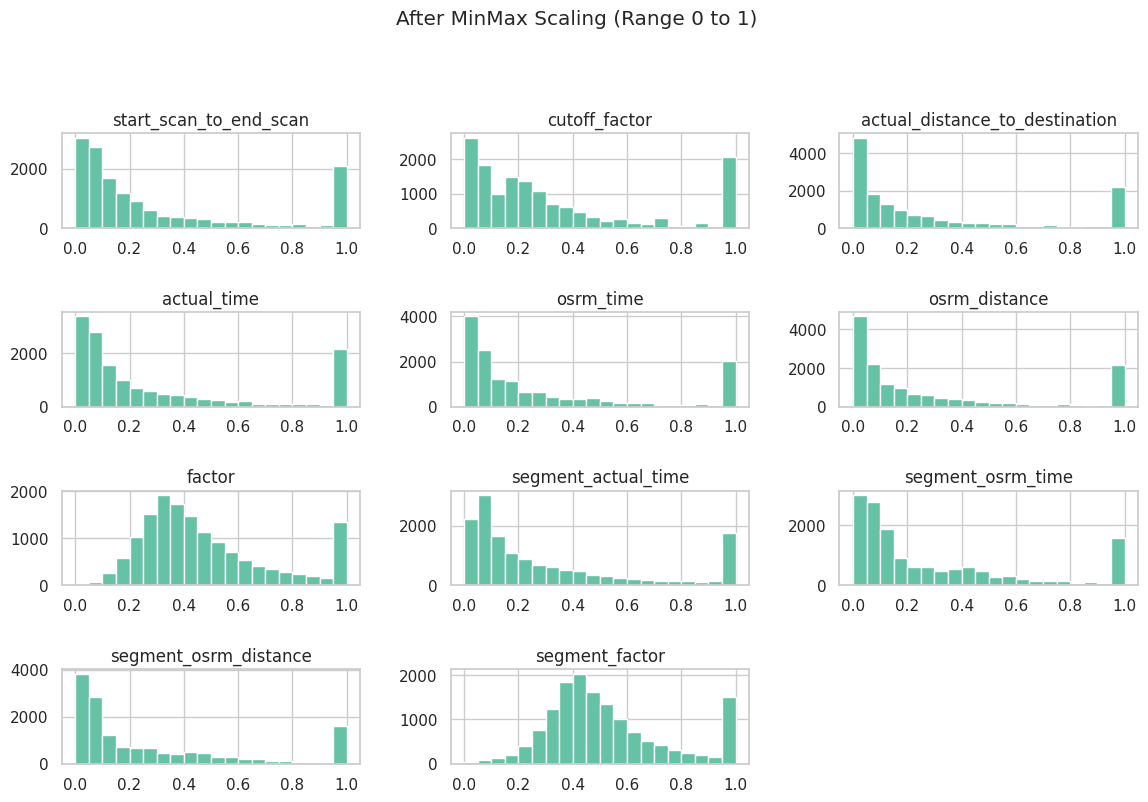

In [557]:
# After MinMax scaling
sns.set_theme(style="whitegrid", palette="Set2")
df_scaled[numerical_columns].hist(figsize=(12, 8), bins=20)
plt.suptitle("After MinMax Scaling (Range 0 to 1)", y=1.02)
plt.tight_layout(pad=2.0)
plt.show()

##**Business Insights - Should include patterns observed in the data along with what you can infer from it.**
### - Check from where most orders are coming from (State, Corridor etc)
### - Busiest corridor, avg distance between them, avg time taken

In [558]:
df_scaled.columns = df_scaled.columns.str.strip()

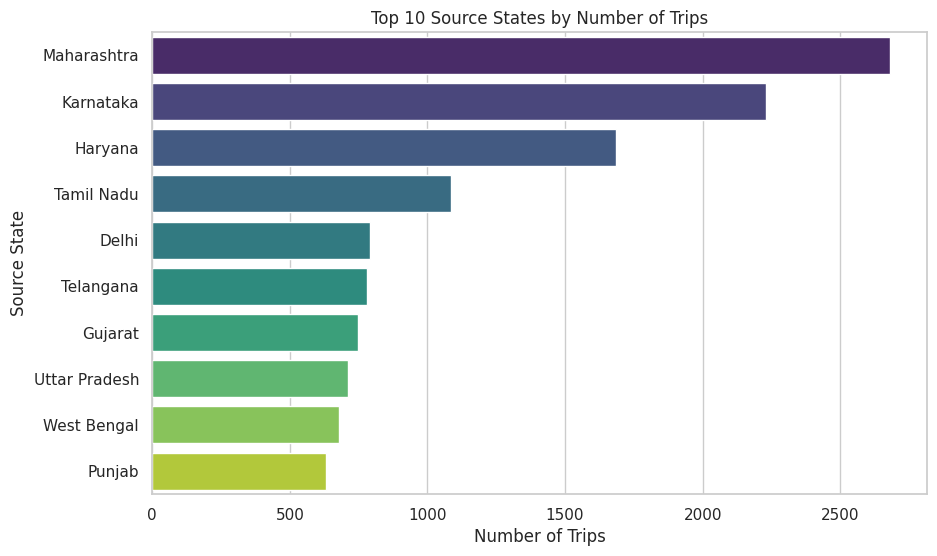

In [559]:
# Orders by State
orders_by_state = df_scaled['source_state'].value_counts().reset_index()
orders_by_state.columns = ['source_state', 'trip_count']

plt.figure(figsize=(10,6))
sns.barplot(data=orders_by_state.head(10),
            x='trip_count',
            y='source_state',
            hue='source_state',
            dodge=False,
            palette='viridis',
            legend=False)
plt.title("Top 10 Source States by Number of Trips")
plt.xlabel("Number of Trips")
plt.ylabel("Source State")
plt.show()

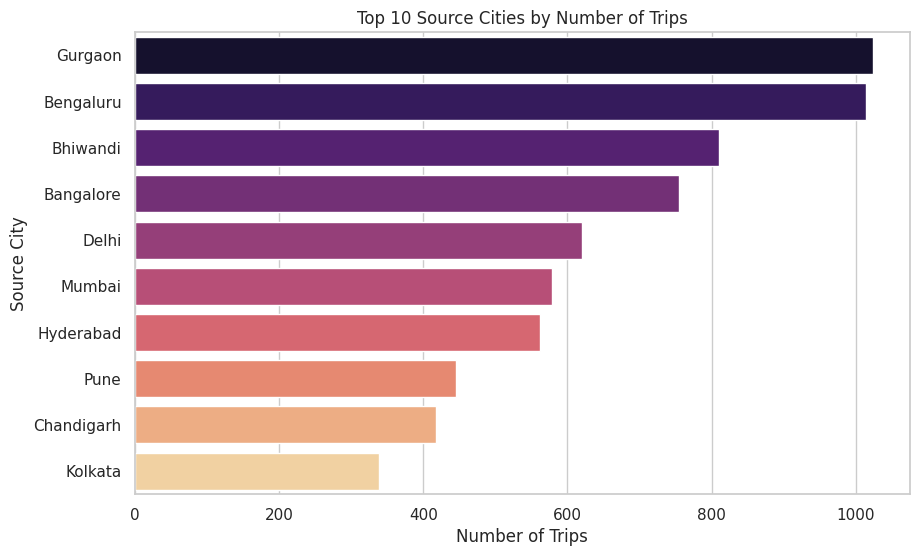

In [560]:
# Orders by City
orders_by_city = df_scaled['source_city'].value_counts().reset_index()
orders_by_city.columns = ['source_city', 'trip_count']

plt.figure(figsize=(10,6))
sns.barplot(data=orders_by_city.head(10), x='trip_count', y='source_city', hue='source_city', dodge=False, palette='magma', legend=False)
plt.title("Top 10 Source Cities by Number of Trips")
plt.xlabel("Number of Trips")
plt.ylabel("Source City")
plt.show()


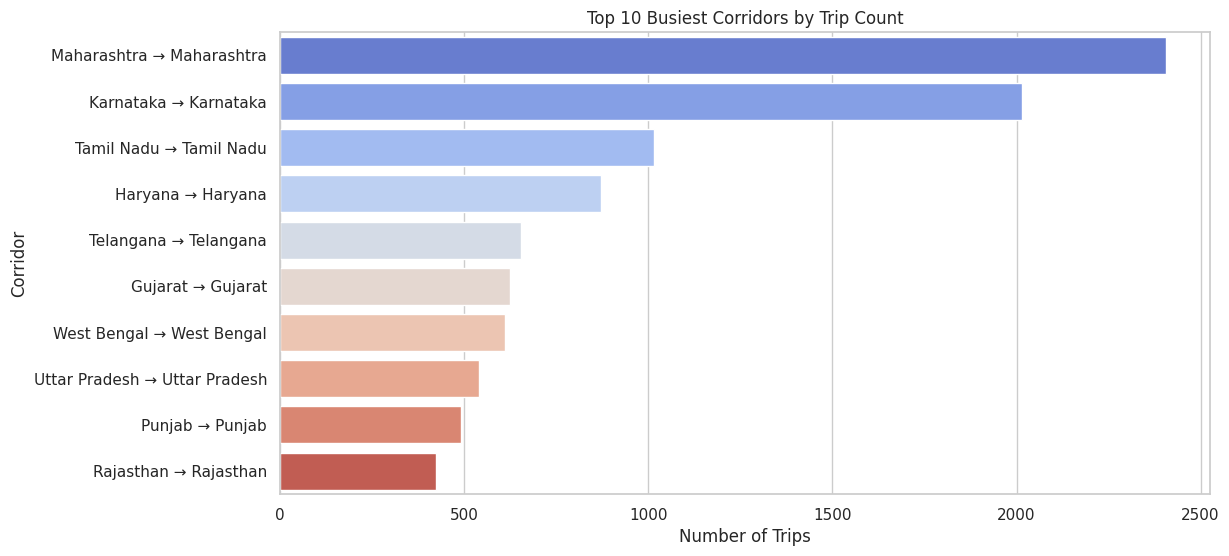

In [561]:
# Create Corridor Column
df_scaled['corridor'] = df_scaled['source_state'] + " → " + df_scaled['destination_state']

# Group by Corridor and calculate stats
corridor_stats = df_scaled.groupby('corridor').agg(
    trip_count=('trip_uuid', 'count'),
    avg_distance=('actual_distance_to_destination', 'mean'),
    avg_time_mins=('total_trip_time_mins', 'mean')
).reset_index()

# Sort by trip_count
corridor_stats = corridor_stats.sort_values(by='trip_count', ascending=False)

# Bar chart for busiest corridors
plt.figure(figsize=(12,6))
sns.barplot(data=corridor_stats.head(10), x='trip_count', y='corridor', hue='corridor', dodge=False, palette='coolwarm', legend=False)
plt.title("Top 10 Busiest Corridors by Trip Count")
plt.xlabel("Number of Trips")
plt.ylabel("Corridor")
plt.show()

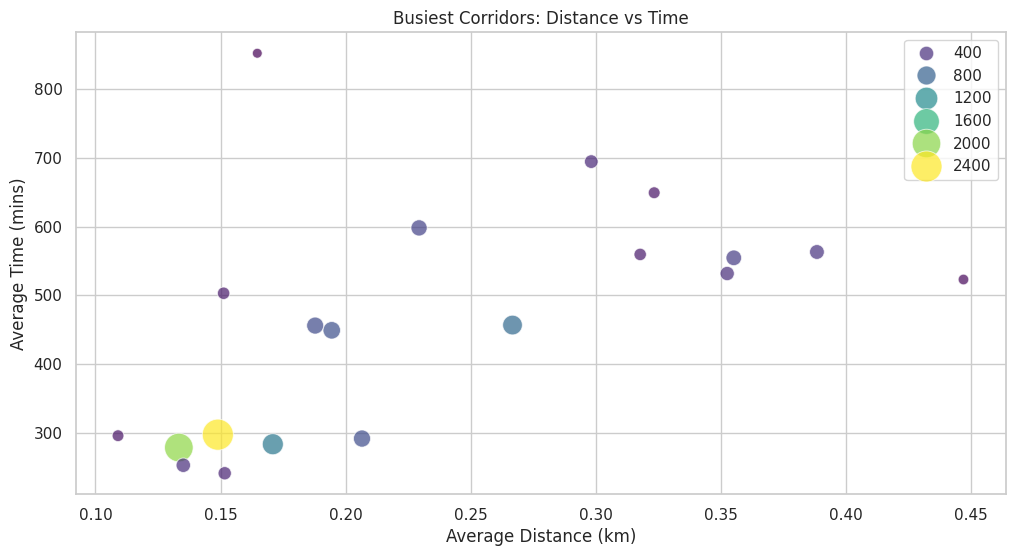

In [562]:
# Bubble Chart for Distance vs Time
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=corridor_stats.head(20),
    x='avg_distance',
    y='avg_time_mins',
    size='trip_count',
    hue='trip_count',
    palette='viridis',
    sizes=(50, 500),
    alpha=0.7
)
plt.title("Busiest Corridors: Distance vs Time")
plt.xlabel("Average Distance (km)")
plt.ylabel("Average Time (mins)")
plt.legend(loc='upper right')
plt.show()

1.State vs. City Performance
 - Top State: Maharashtra

 - Top City: Gurgaon (Haryana)

 - This indicates that while Maharashtra dominates overall due to multiple strong-performing cities (e.g., Mumbai, Pune), Gurgaon alone outperforms any single city in Maharashtra.

**Implication:**

- Marketing and sales strategies can be state-wide for Maharashtra but city-focused for Gurgaon.

- Maharashtra’s revenue is more distributed, while Gurgaon’s is more concentrated — meaning dependency risk if Gurgaon’s performance drops.

2.Customer Distribution
- Sales are spread across multiple states, but a few cities account for a major chunk of orders.

- There is likely a Pareto effect — top 20% of cities generating 80% of revenue.

**Implication:**

- Focus retention programs on these top cities to maintain revenue stability.

- For smaller cities, low-cost online marketing campaigns could help unlock untapped demand.

3.Risk of Over-Reliance
- If Gurgaon is the highest-selling city, but the state of Haryana is not in the top position, that means other Haryana cities contribute very little.

**Implication:**

- Need to diversify sales in Haryana beyond Gurgaon to reduce dependency risk.

- Explore cross-selling in nearby NCR cities (Faridabad, Noida).

4.Growth Opportunities

- States like Maharashtra already have strong penetration, but second-tier cities in that state could be leveraged for further growth.

- Gurgaon’s success model could be replicated in other metro business hubs.

**Recommendations - Actionable items for business. No technical jargon. No complications. Simple action items that everyone can understand.**

Recommendations – Priority Order

1. Focus on Maharashtra and Haryana – Strengthen presence where sales are already strong to get quick wins.

2. Boost Gurgaon Sales Further – Double down on the top-performing city with targeted offers and loyalty programs.

3. Promote High-Demand Products in Top States – Push best-sellers in high-demand areas for maximum profit.

4. Encourage Repeat Orders – Simple follow-ups and offers to existing customers can increase sales without high costs.

5. Target Underperforming States – Run campaigns to attract new customers in low-sales states.

6. Improve Delivery in Low-Performing Areas – Better service can help turn occasional buyers into loyal customers.

7. Seasonal Offers – Use festive seasons to give a big short-term sales boost.

8. Expand Presence in Tier-2 Cities – Tap into growth potential in smaller but upcoming markets.

9. Strengthen Relationships with Local Partners – Collaborations can help in both expanding reach and improving supply.

10. Collect Customer Feedback – Use insights to make gradual service and product improvements over time.